In [1]:
import os, re, random, math, json, pdb
from main import np, torch, Vocab, Mutex, RecordLoss, encode, encode_io, collate, eval_format, get_fig2_exp, NoamLR, SoftAlign
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, namedtuple
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
from uncertainties import ufloat
from scipy import stats
import seaborn as sns

[<StreamHandler stdout (INFO)>]


In [2]:
def mean_std(x):
    return ufloat(np.mean(x),np.std(x))
def my_mean(x):
    return(str(round(np.mean(x),2)))
def sort_by(list1, list2):
    return [x for _,x in sorted(zip(list2,list1))]

In [3]:
ROOT_FOLDER=os.getcwd()

In [4]:
ROOT_FOLDER

'/home/gridsan/eakyurek/git/mutex'

In [5]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({"text.usetex": False,"font.family": "sans-serif"})
plt.rcParams['figure.facecolor'] = 'white'

In [6]:
MetaInfo = namedtuple('MetaInfo','data, vocab_x, vocab_y, references')
ExpInfo = namedtuple('ExpInfo','configs results')

In [7]:
def read_logs_geca(log_file, datainfo=None, read_category=False, read_references=False):
    ext = re.compile("train/\\d+/eval_test/(\\d+)/(.*?)\s(.*?)$")
    with open(log_file,'r') as f:
        log_lines = f.readlines()
    if read_category and (datainfo is not None):
        inps = dict((" ".join(datainfo.vocab_x.decode(inp[1:-1])),datainfo.data['gen_cats'][i])  for (i,(inp,out)) in enumerate(datainfo.data['gen']))
    expinfo = {}
    results = []

    for l in log_lines:
        l = l.strip()
        if "# --" in l:
            option = l.split("# --")[-1]
            if "=" in option:
                k,v = option.split("=")
                expinfo[k] = v
            else:
                if option.startswith('no'):
                    expinfo[option[2:]] = False
                else:
                    expinfo[option] = True
        else:
            match = ext.search(l)
            if match is not None:
                idx, info, value = match.groups(0)
                idx = int(idx) + 1
                if int(idx) > len(results):
                    results.append({})
                val = value.split(" ")
                if info == "corr":
                    info = "label"
                    val  = val[0] == "1"
                results[int(idx)-1][info] = val
                if info == "input" and datainfo is not None:
                    if read_category:
                        results[int(idx)-1]["category"] = inps[" ".join(val)]
                    if read_references:
                        results[int(idx)-1]["references"] = datainfo.references['<s> '+ " ".join(val) + ' </s>']
                    if "rare_words" in datainfo.data:
                        results[int(idx)-1]["rare"] = any(w in val for w in datainfo.data["rare_words"])
                        
    if "aligner" in expinfo and expinfo["aligner"] not in ("","uniform","random"):
        with open(expinfo["aligner"].split("//")[-1],"r") as f:
            expinfo["alignment"] = json.load(f)

    if len(results) == 0:
        return None
    return ExpInfo(configs=expinfo,results=results)

In [8]:
def read_logs(log_file, datainfo=None, read_category=False, read_references=False):
    ext = re.compile("test evaluation \(greedy\)/(\\d+)/(.*?)\s(.*?)$")
    with open(log_file,'r') as f:
        log_lines = f.readlines()
    if read_category and (datainfo is not None):
        inps = dict((" ".join(datainfo.vocab_x.decode(inp[1:-1])),datainfo.data['gen_cats'][i])  for (i,(inp,out)) in enumerate(datainfo.data['gen']))
    expinfo = {}
    results = []

    for l in log_lines:
        l = l.strip()
        if "# --" in l:
            option = l.split("# --")[-1]
            if "=" in option:
                k,v = option.split("=")
                expinfo[k] = v
            else:
                if option.startswith('no'):
                    expinfo[option[2:]] = False
                else:
                    expinfo[option] = True
        else:
            match = ext.search(l)
            if match is not None:
                idx, info, value = match.groups(0)
                if int(idx) > len(results):
                    results.append({})
                val = eval(value)
                results[int(idx)-1][info] = val
                if info == "input" and datainfo is not None:
                    if read_category:
                        results[int(idx)-1]["category"] = inps[" ".join(val)]
                    if read_references:
                        results[int(idx)-1]["references"] = datainfo.references['<s> '+ " ".join(val) + ' </s>']
                    if "rare_words" in datainfo.data:
                        results[int(idx)-1]["rare"] = any(w in val for w in datainfo.data["rare_words"])
                        
    
    if "seed" in  expinfo and expinfo["seed"] == '0' and  "aligner" in expinfo and expinfo["aligner"] not in ("","uniform","random"):
        with open(expinfo["aligner"].split("//")[-1],"r") as f:
            expinfo["alignment"] = json.load(f)

    if len(results) == 0:
        return None
    return ExpInfo(configs=expinfo,results=results)

In [9]:
def read_from_protogen_logs(log_file, datainfo=None, read_category=False, read_references=False):
    assert datainfo is not None and read_category == False and read_references == False
    with open(log_file,'r') as f:
        log_lines = f.readlines()
    inps = [" ".join(datainfo.vocab_x.decode(inp)) for (i,(inp,out)) in enumerate(datainfo.data['test'])]
    inps_nospace = ["".join(datainfo.vocab_x.decode(inp)) for (i,(inp,out)) in enumerate(datainfo.data['test'])]
    expinfo = {}
    results = []
    started = False
    idx = 0
    for l in log_lines:
        l = l.strip()
        if not started and l.startswith("TEST EVALS"):
            started = True
        elif l.startswith("VAL EVALS"):
            started= False
        elif started:
            if l.startswith("INPUT:"):
                idx += 1
                results.append({})
                _, inp, label = l.split(" ")
                label = True if label == "true" else False
                results[idx-1]['label'] = label
#                 pdb.set_trace()
                inp=inp.replace("🎬","<s>").replace("🏁","</s>")
                results[idx-1]['input'] = inps[inps_nospace.index(inp)]            
            elif l.startswith("REF:"):
                results[idx-1]['gold'] = l.split("REF: ")[-1].split(" ")
            elif l.startswith("PRED:"):
                results[idx-1]['pred'] = l.split("PRED: ")[-1].split(" ")
    if len(results) == 0:
        return None
    return ExpInfo(configs=expinfo,results=results)

## SCAN

In [10]:
def read_scan(scan_split="around_right", seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    vocab_x = Vocab()
    vocab_y = Vocab()
    references = None
    data = {}
    max_len_x, max_len_y = 0, 0
    reg = re.compile('^IN\:\s(.*?)\sOUT\: (.*?)$')
    if scan_split == "around_right":
        scan_file = ROOT_FOLDER + "/SCAN/template_split/tasks_{}_template_around_right.txt"
    else:
        scan_file = ROOT_FOLDER + "/SCAN/add_prim_split/tasks_{}_addprim_jump.txt"
    for split in ("train", "test"):
        split_data = []
        for l in open(scan_file.format(split),"r").readlines():
            m = reg.match(l)
            inp, out = m.groups(1)
            inp, out = (inp.split(" "), out.split(" "))
            max_len_x = max(len(inp),max_len_x)
            max_len_y = max(len(out),max_len_y)
            for t in inp:
                vocab_x.add(t)
            for t in out:
                vocab_y.add(t)
            split_data.append(encode_io((inp,out),vocab_x,vocab_y))
        data[split] = split_data

    val_size = math.floor(len(data["train"])*0.01)
    train_size = len(data["train"])-val_size
    train_items, val_items = torch.utils.data.random_split(data["train"],[train_size, val_size])
    test_items = data["test"]
    max_len_x+=1
    max_len_y+=1
    print("vocab_x len: ", len(vocab_x))
    print("vocab_y len: ", len(vocab_y))
    print("split lengts: ", [(k,len(v)) for (k,v) in data.items()])
    return MetaInfo(data=data, vocab_x=vocab_x,vocab_y=vocab_y, references=references)

In [11]:
scaninfo = read_scan(scan_split="around_right", seed=0)

vocab_x len:  18
vocab_y len:  11
split lengts:  [('train', 15225), ('test', 4476)]


In [12]:
#scan_expinfo = read_logs(f"{ROOT_FOLDER}/exp/SCAN/0.5aligner_jump_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/eval.0.out")
scan_expinfo = read_logs(f"{ROOT_FOLDER}/exp/SCAN/jump_simple/eval.0.out")

In [13]:
scan_geca_expinfo = read_from_protogen_logs("/home/gridsan/eakyurek/git/protogen/checkpoints_scan_geca/SCANDataSet/logs/2proto.vae.false.around_right.seed.0.cond.log", datainfo=scaninfo)

## COLORS

In [14]:
def read_colors(full_data=True, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    vocab_x = Vocab()
    vocab_y = Vocab()
    references = None
    #input_symbols_list   = set(['red', 'yellow', 'green', 'blue', 'purple', 'pink', 'around', 'thrice', 'after'])
    #state = random.getstate()
    # random.seed(0)
    input_symbols_list  = set(['dax', 'lug', 'wif', 'zup', 'fep', 'blicket', 'kiki', 'tufa', 'gazzer'])
    output_symbols_list = set(['RED', 'YELLOW', 'GREEN', 'BLUE', 'PURPLE', 'PINK'])
    study, test = get_fig2_exp(input_symbols_list, output_symbols_list)
    #random.setstate(state)

    if full_data:
        for sym in input_symbols_list:
            vocab_x.add(sym)
        for sym in output_symbols_list:
            vocab_y.add(sym)
        max_len_x = 7
        max_len_y = 9
    else:
        test, study  = study[3:4], study[0:3]
        for (x,y) in test+study:
            for sym in x:
                vocab_x.add(sym)
            for sym in y:
                vocab_y.add(sym)
        max_len_x = 2
        max_len_y = 2

    data = {}
    train_items, test_items = encode(study, vocab_x, vocab_y), encode(test,vocab_x, vocab_y)
    data['train'] = train_items
    data['test'] = test_items
    val_items = test_items #TODO: create a val set
    return MetaInfo(data=data, vocab_x=vocab_x,vocab_y=vocab_y, references=references)

In [15]:
colorsinfo = read_colors()

In [16]:
colorsinfo

MetaInfo(data={'train': [([1, 8, 2], [1, 6, 2]), ([1, 13, 2], [1, 5, 2]), ([1, 12, 2], [1, 9, 2]), ([1, 7, 2], [1, 10, 2]), ([1, 13, 10, 2], [1, 5, 5, 5, 2]), ([1, 8, 10, 2], [1, 6, 6, 6, 2]), ([1, 13, 9, 12, 2], [1, 5, 9, 5, 2]), ([1, 12, 9, 8, 2], [1, 9, 6, 9, 2]), ([1, 13, 11, 12, 2], [1, 9, 5, 2]), ([1, 8, 11, 13, 2], [1, 5, 6, 2]), ([1, 13, 10, 11, 12, 2], [1, 9, 5, 5, 5, 2]), ([1, 12, 11, 8, 9, 13, 2], [1, 6, 5, 6, 9, 2]), ([1, 13, 11, 12, 10, 2], [1, 9, 9, 9, 5, 2]), ([1, 12, 9, 8, 11, 13, 2], [1, 5, 9, 6, 9, 2])], 'test': [([1, 7, 10, 2], [1, 10, 10, 10, 2]), ([1, 7, 9, 13, 2], [1, 10, 5, 10, 2]), ([1, 8, 9, 7, 2], [1, 6, 10, 6, 2]), ([1, 7, 11, 8, 2], [1, 6, 10, 2]), ([1, 12, 11, 7, 2], [1, 10, 9, 2]), ([1, 7, 10, 11, 13, 2], [1, 5, 10, 10, 10, 2]), ([1, 12, 11, 7, 10, 2], [1, 10, 10, 10, 9, 2]), ([1, 13, 11, 12, 9, 7, 2], [1, 9, 10, 9, 5, 2]), ([1, 7, 9, 12, 11, 8, 10, 2], [1, 6, 6, 6, 10, 9, 10, 2]), ([1, 7, 9, 7, 11, 7, 10, 2], [1, 10, 10, 10, 10, 10, 10, 2])]}, vocab_x=<sr

In [17]:
color_expinfo = read_logs(f"{ROOT_FOLDER}/exp/COLOR/simple/eval.0.out")

## COGS

In [18]:
def read_cogs(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    vocab_x = Vocab()
    vocab_y = Vocab()
    references = None
    data = {}
    max_len_x, max_len_y = 0, 0
    count_x, count_y = Counter(), Counter()
    for split in ("train", "dev", "test", "gen"):
        split_data = []
        split_cats = []
        for l in open(f"{ROOT_FOLDER}/COGS/cogs/{split}.tsv","r").readlines():
            text, sparse, category = l.split("\t")
            text, sparse    = (text.split(" "), sparse.split(" "))
            max_len_x = max(len(text),max_len_x)
            max_len_y = max(len(sparse),max_len_y)
            for t in text:
                vocab_x.add(t)
                if split == "train":
                    count_x[t] += 1
                vocab_y.add(t)
            for t in sparse:
                vocab_y.add(t)
                vocab_x.add(t)
                if split == "train":
                    count_y[t] += 1
            split_cats.append(category.strip())
            split_data.append(encode_io((text,sparse),vocab_x,vocab_y))
        data[split] = split_data
        data[split + '_cats'] = split_cats
    max_len_x+=1
    max_len_y+=1
    data['rare_words'] = [x for x, count in count_x.items() if count == 1]

    print("vocab_x len: ", len(vocab_x))
    print("vocab_y len: ", len(vocab_y))
    print("split lengts: ", [(k,len(v)) for (k,v) in data.items()])
    return MetaInfo(data=data, vocab_x=vocab_x,vocab_y=vocab_y, references=references)

In [19]:
cogsinfo = read_cogs()

vocab_x len:  876
vocab_y len:  876
split lengts:  [('train', 24155), ('train_cats', 24155), ('dev', 3000), ('dev_cats', 3000), ('test', 3000), ('test_cats', 3000), ('gen', 21000), ('gen_cats', 21000), ('rare_words', 85)]


In [20]:
len(cogsinfo.data['gen'])

21000

In [21]:
#cogs_expinfo = read_logs(f"{ROOT_FOLDER}/exp/COGS/aligner_COGS_lr_1.0_warmup_4000_max_8000/eval.1.out", datainfo=cogsinfo, read_category=True)
cogs_expinfo = read_logs(f"{ROOT_FOLDER}/exp/COGS/simple/eval.1.out", datainfo=cogsinfo, read_category=True)

In [22]:
cogs_expinfo.results[0]

{'label': False,
 'tp': 217,
 'fp': 5,
 'fn': 52,
 'input': ['Camila',
  'wished',
  'that',
  'Emma',
  'noticed',
  'that',
  'a',
  'butterfly',
  'admired',
  'that',
  'the',
  'professor',
  'believed',
  'that',
  'Mia',
  'liked',
  'that',
  'Liam',
  'appreciated',
  'that',
  'the',
  'giraffe',
  'liked',
  'that',
  'William',
  'proved',
  'that',
  'Zoe',
  'noticed',
  'that',
  'the',
  'zebra',
  'thought',
  'that',
  'Leo',
  'liked',
  'that',
  'Ava',
  'confessed',
  'that',
  'the',
  'plate',
  'burned',
  '.'],
 'category': 'cp_recursion',
 'rare': False,
 'gold': ['*',
  'professor',
  '(',
  'x',
  '_',
  '11',
  ')',
  ';',
  '*',
  'giraffe',
  '(',
  'x',
  '_',
  '21',
  ')',
  ';',
  '*',
  'zebra',
  '(',
  'x',
  '_',
  '31',
  ')',
  ';',
  '*',
  'plate',
  '(',
  'x',
  '_',
  '41',
  ')',
  ';',
  'wish',
  '.',
  'agent',
  '(',
  'x',
  '_',
  '1',
  ',',
  'Camila',
  ')',
  'AND',
  'wish',
  '.',
  'ccomp',
  '(',
  'x',
  '_',
  '1',
  ',',


## TRANSLATE

In [23]:
def read_translate(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    vocab_x = Vocab()
    vocab_y = Vocab()
    references = None
    data = {}
    max_len_x, max_len_y = 0, 0
    count_x, count_y = Counter(), Counter()
    count_x_train = Counter()
    for split in ("train", "dev", "test"):
        split_data = []
        translate_file = f"{ROOT_FOLDER}/TRANSLATE/cmn.txt_{split}_tokenized.tsv"
        for l in open(translate_file,"r").readlines():
            input, output = l.split("\t")
            inp, out = (input.strip().split(" "), output.strip().split(" "))
            max_len_x = max(len(inp),max_len_x)
            max_len_y = max(len(out),max_len_y)
            for t in inp:
                count_x[t] += 1
                if split == "train":
                    count_x_train[t] += 1
            for t in out:
                count_y[t] += 1
            split_data.append((inp,out))

        data[split] = split_data


    # pdb.set_trace()
    count_x  = count_x.most_common(15000) #threshold to 10k words
    count_y  = count_y.most_common(26000) #threshold to 10k words

    for (x,_) in count_x:
        vocab_x.add(x)
    for (y,_) in count_y:
        vocab_y.add(y)

    edata = {}
    references = {}
    for (split,split_data) in data.items():
        esplit = []
        for (inp,out) in split_data:
            (einp, eout) = encode_io((inp,out),vocab_x,vocab_y)
            esplit.append((einp, eout))
            sinp = " ".join(vocab_x.decode(einp))
            if sinp in references:
                references[sinp].append(out)
            else:
                references[sinp] = [out]
        edata[split] = esplit
    data = edata

    data['rare_words'] = [x for x, count in count_x_train.items() if count == 1]

    max_len_x+=1
    max_len_y+=1
    print("vocab_x len: ", len(vocab_x))
    print("vocab_y len: ", len(vocab_y))
    print("split lengts: ", [(k,len(v)) for (k,v) in data.items()])

    train_items  = data["train"]
    val_items    = data["dev"]
    test_items   = data["test"]
    return MetaInfo(data=data, vocab_x=vocab_x,vocab_y=vocab_y, references=references)

In [24]:
translateinfo = read_translate()

vocab_x len:  7292
vocab_y len:  12699
split lengts:  [('train', 19222), ('dev', 2402), ('test', 2402), ('rare_words', 2809)]


In [25]:
#translate_expinfo = read_logs(f"{ROOT_FOLDER}/exp/TRANSLATE/aligner_TRANSLATE_lr_1.0_warmup_4000_max_8000/eval.0.out", datainfo=translateinfo, read_references=True)
translate_expinfo = read_logs(f"{ROOT_FOLDER}/exp/TRANSLATE/simple/eval.0.out", datainfo=translateinfo, read_references=True)

In [26]:
translate_expinfo.results[0];

In [27]:
def get_labels(results, rare=False, category=None):
    if not rare:
        if category is None:
            labels = [res['label'] for res in results]
        else:
            labels = [res['label'] for res in results if category in res['category']]
    else:
        labels = [res['label'] for res in results if res['rare']]
        
    return labels

def get_preds_references(results, rare=False):
    preds = []
    references = []
    for res in results:
        if rare:
            if res['rare']:
                preds.append(res['pred'])
                references.append(res['references'])
        else:
            preds.append(res['pred'])
            references.append(res['references'])
    return (references, preds)

def get_accuracy(arr_results, rare=False, category=None):
    arr_labels = [get_labels(res, rare=rare, category=category) for res in arr_results]
    means = [np.mean(labels) for labels in arr_labels]
    return mean_std(means)

def sort_inputs(results):
    return sorted(results, key=lambda k: k['input'])

from scipy import stats

def flatten(t):
    return [item for sublist in t for item in sublist]

def get_t_test(arr_results1, arr_results2, rare=False, category=None):
    arr_labels1 = flatten([get_labels(sort_inputs(res), rare=rare, category=category) for res in arr_results1])
    arr_labels2 = flatten([get_labels(sort_inputs(res), rare=rare, category=category) for res in arr_results2])
    return stats.ttest_rel(np.array(arr_labels1).astype(int), np.array(arr_labels2).astype(int)).pvalue

# from IPython.core.debugger import Tracer

def get_bleu(arr_results, rare=False):
    arr_labels = [get_preds_references(res, rare=rare) for res in arr_results]
    bleus = [corpus_bleu(*labels) for labels in arr_labels]
    return mean_std(bleus)


In [28]:
around_right_info = read_scan(scan_split="around_right", seed=0)
jump_info = read_scan(scan_split="jump", seed=0)

vocab_x len:  18
vocab_y len:  11
split lengts:  [('train', 15225), ('test', 4476)]
vocab_x len:  18
vocab_y len:  11
split lengts:  [('train', 14670), ('test', 7706)]


In [29]:
translateinfo.data.keys()

dict_keys(['train', 'dev', 'test', 'rare_words'])

In [30]:
print(pd.DataFrame({"around_right": { "train": len(around_right_info.data['train']), "test": len(around_right_info.data['test'])},
 "jump": {"train": len(jump_info.data['train']), "test": len(jump_info.data['test'])},
 "COGS": {"train": len(cogsinfo.data['train']), "val": len(cogsinfo.data['dev']), "test":len(cogsinfo.data['gen'])},
 "Colors": {"train": len(colorsinfo.data['train']),"test":len(colorsinfo.data['test'])},
 "ENG-CHN": {"train": len(translateinfo.data['train']), "val": len(translateinfo.data['dev']), "test":len(translateinfo.data['test'])},
}).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  around\_right &     jump &   COGS &  Colors &  ENG-CHN \\
\midrule
train &       15225.0 &  14670.0 &  24155 &    14.0 &    19222 \\
test  &        4476.0 &   7706.0 &  21000 &    10.0 &     2402 \\
val   &           NaN &      NaN &   3000 &     NaN &     2402 \\
\bottomrule
\end{tabular}



In [31]:
get_accuracy([scan_expinfo.results])

0.9948092395535946+/-0

In [32]:
get_bleu([translate_expinfo.results], rare=True)

0.18465612153073022+/-0

# Main Results

In [33]:
exp_home="exp/"

In [34]:
def read_all_results(exp_folders, exp_name, datainfo=None, rng=range(10), fnameformat = "eval.{}.out", read_references=False, read_category=False):
    exp_results = {}
    for (model_name, folder) in exp_folders.items():
        results = []
        for i in rng:
            if not model_name.startswith("geca"):
                exp_file = folder +  f"eval.{i}.out"
                reader = read_logs
            elif model_name == "geca":
                exp_file = folder + f"2proto.vae.false.{exp_name}.seed.{i}.cond.log"
                reader = read_from_protogen_logs
            elif model_name == "geca_j":
                exp_file = folder +  f"eval.{i}.out"
                reader = read_logs_geca
                
            if os.path.exists(exp_file):
                result = reader(exp_file, datainfo=datainfo, read_references=read_references, read_category=read_category)
                if result is None:
                    print(model_name, f" seed {i} not complete")
                else:
                    results.append(result)
            else:
                print(model_name, f" seed {i} is missing")
        exp_results[model_name] = results
    return exp_results

In [35]:
main_table_scores = {}
main_table_significance = {}

## SCAN Results

In [36]:
scan_home = exp_home + "SCAN/"
geca_home = "/home/gridsan/eakyurek/git/protogen/checkpoints_scan_geca/SCANDataSet/logs/"

### Around Right

In [37]:
def around_right(datainfo=None):
    prefix = scan_home + "around_right_"
    exp_folders = {"lstm":scan_home + "LSTM_around_right_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/",
    "lstmcopy":scan_home + "LSTM_around_right_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/",
    "simple": prefix + "simple/",
    "pmi":prefix + "pmi/",
    "intersect": prefix + "fast_intersect/",
    "forward": scan_home + "fast_forward_around_right_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/",
    "goodman":prefix + "goodman/",
    "geca":geca_home,
    "synatt": f"{ROOT_FOLDER}/syntactic_attention/around_right_logs/"}
    return read_all_results(exp_folders, "around_right", datainfo=datainfo)

In [38]:
main_table_scores["around_right"] = {}
main_table_significance["around_right"] = {}

In [39]:
around_right_results = around_right(datainfo=read_scan(scan_split="around_right", seed=0))

vocab_x len:  18
vocab_y len:  11
split lengts:  [('train', 15225), ('test', 4476)]


In [40]:
for (exp_name, results) in around_right_results.items():
    main_table_scores["around_right"][exp_name] = get_accuracy([result.results for result in results])

In [41]:
main_table_scores

{'around_right': {'lstm': 0.08646112600536192+/-0.045231659739827956,
  'lstmcopy': 0.08646112600536192+/-0.045231659739827956,
  'simple': 0.9493967828418229+/-0.012642238428318108,
  'pmi': 0.020352993744414658+/-0.034984405194322846,
  'intersect': 0.00020107238605898123+/-0.0004052358611978788,
  'forward': 0.00020107238605898123+/-0.0004052358611978788,
  'goodman': 0.02064343163538874+/-0.03909743393335053,
  'geca': 0.9849865951742626+/-0.019047330258969555,
  'synatt': 0.27625111706881145+/-0.2578109680038039}}

In [42]:
def update_significance(results, significances, rare=False):
    for m1 in results.keys():
        significances[m1] = {}
        for m2 in results.keys():
            if m1 != m2:
                results1 = [result.results for result in results[m1]]
                results2 = [result.results for result in results[m2]]
                significances[m1][m2] = get_t_test(results1, results2,rare=rare)

In [43]:
update_significance(around_right_results,main_table_significance["around_right"])

In [44]:
main_table_significance["around_right"]

{'lstm': {'lstmcopy': nan,
  'simple': 0.0,
  'pmi': 0.0,
  'intersect': 0.0,
  'forward': 0.0,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'lstmcopy': {'lstm': nan,
  'simple': 0.0,
  'pmi': 0.0,
  'intersect': 0.0,
  'forward': 0.0,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'simple': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'pmi': 0.0,
  'intersect': 0.0,
  'forward': 0.0,
  'goodman': 0.0,
  'geca': 2.279297480028008e-225,
  'synatt': 0.0},
 'pmi': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'simple': 0.0,
  'intersect': 2.988191268913685e-196,
  'forward': 2.988191268913685e-196,
  'goodman': 0.7285444606257238,
  'geca': 0.0,
  'synatt': 0.0},
 'intersect': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'simple': 0.0,
  'pmi': 2.988191268913685e-196,
  'forward': nan,
  'goodman': 3.918865233308645e-199,
  'geca': 0.0,
  'synatt': 0.0},
 'forward': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'simple': 0.0,
  'pmi': 2.988191268913685e-196,
  'intersect': nan,
  'goodman': 3.918865233308645e-199,
  '

### JUMP

In [45]:
def jump(datainfo=None):
    prefix = scan_home + "jump_"
    exp_folders = {"lstm":scan_home + "LSTM_jump_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/",
    "lstmcopy":scan_home + "LSTM_jump_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/",
    "simple": prefix + "simple/",
    "pmi":prefix + "pmi/",
    "intersect": prefix + "fast_intersect/",
    "forward": prefix+ "simple/",
    "goodman":prefix + "goodman/",
    "geca":geca_home,
    "synatt": f"{ROOT_FOLDER}/syntactic_attention/jump_logs/"}
    return read_all_results(exp_folders, "jump", datainfo=datainfo, read_references=False)

In [46]:
main_table_significance["jump"] = {}

In [47]:
main_table_scores["jump"] = {}
jump_results = jump(datainfo=read_scan(scan_split="jump", seed=0))

vocab_x len:  18
vocab_y len:  11
split lengts:  [('train', 14670), ('test', 7706)]


In [48]:
for (exp_name, results) in jump_results.items():
#     print(exp_name, " ", len(results))
#     print(np.sum([len(result.results) for result in results]))
    main_table_scores["jump"][exp_name] = get_accuracy([result.results for result in results])

In [49]:
main_table_scores['jump']

{'lstm': 0.0040877238515442515+/-0.0034491470476186144,
 'lstmcopy': 0.0040877238515442515+/-0.0034491470476186144,
 'simple': 0.9168569945497016+/-0.17091975971191123,
 'pmi': 0.954684661302881+/-0.0816483642264005,
 'intersect': 0.7905528159875421+/-0.26787430886295,
 'forward': 0.9168569945497016+/-0.17091975971191123,
 'goodman': 0.8161302880872048+/-0.28978730899164934,
 'geca': 0.9994030625486634+/-0.000993729027722646,
 'synatt': 0.5727744614586037+/-0.38042580893911965}

In [50]:
update_significance(jump_results,main_table_significance["jump"])

In [51]:
main_table_significance["jump"]

{'lstm': {'lstmcopy': nan,
  'simple': 0.0,
  'pmi': 0.0,
  'intersect': 0.0,
  'forward': 0.0,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'lstmcopy': {'lstm': nan,
  'simple': 0.0,
  'pmi': 0.0,
  'intersect': 0.0,
  'forward': 0.0,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'simple': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'pmi': 4.990718693820838e-234,
  'intersect': 0.0,
  'forward': nan,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'pmi': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'simple': 4.990718693820838e-234,
  'intersect': 0.0,
  'forward': 4.990718693820838e-234,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'intersect': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'simple': 0.0,
  'pmi': 0.0,
  'forward': 0.0,
  'goodman': 2.0452490805398883e-94,
  'geca': 0.0,
  'synatt': 0.0},
 'forward': {'lstm': 0.0,
  'lstmcopy': 0.0,
  'simple': nan,
  'pmi': 4.990718693820838e-234,
  'intersect': 0.0,
  'goodman': 0.0,
  'geca': 0.0,
  'synatt': 0.0},
 'goodman': {'lstm': 0.

### Colors

In [52]:
color_home = exp_home + "COLOR/"

In [53]:
def colors():
    exp_folders = {"lstm":color_home + "LSTM_nbatch_5_dim_128_lr_0.001/",
                   "lstmcopy":color_home + "LSTM_nbatch_5_dim_128_lr_0.001/",
                   "simple":color_home + "simple/",
                   "pmi":color_home + "pmi/",
                   "intersect":color_home + "fast_intersect/",
                   "forward":color_home + "fast_forward/",
                   "goodman":color_home + "goodman/",
                    "gecax": color_home + "geca_nbatch_14_dim_256_lr_0.001_paug_0.3/",
                   "synatt": f"{ROOT_FOLDER}/syntactic_attention/color_logs/"}
    return read_all_results(exp_folders, "colors", rng=range(16))

In [54]:
colors_results = colors()
colors_results['geca'] = colors_results.pop('gecax')
main_table_scores["Colors"] = {}
for (exp_name, results) in colors_results.items():
    main_table_scores["Colors"][exp_name] = get_accuracy([result.results for result in results])

In [55]:
main_table_scores

{'around_right': {'lstm': 0.08646112600536192+/-0.045231659739827956,
  'lstmcopy': 0.08646112600536192+/-0.045231659739827956,
  'simple': 0.9493967828418229+/-0.012642238428318108,
  'pmi': 0.020352993744414658+/-0.034984405194322846,
  'intersect': 0.00020107238605898123+/-0.0004052358611978788,
  'forward': 0.00020107238605898123+/-0.0004052358611978788,
  'goodman': 0.02064343163538874+/-0.03909743393335053,
  'geca': 0.9849865951742626+/-0.019047330258969555,
  'synatt': 0.27625111706881145+/-0.2578109680038039},
 'jump': {'lstm': 0.0040877238515442515+/-0.0034491470476186144,
  'lstmcopy': 0.0040877238515442515+/-0.0034491470476186144,
  'simple': 0.9168569945497016+/-0.17091975971191123,
  'pmi': 0.954684661302881+/-0.0816483642264005,
  'intersect': 0.7905528159875421+/-0.26787430886295,
  'forward': 0.9168569945497016+/-0.17091975971191123,
  'goodman': 0.8161302880872048+/-0.28978730899164934,
  'geca': 0.9994030625486634+/-0.000993729027722646,
  'synatt': 0.572774461458603

In [56]:
main_table_significance["Colors"] = {}
update_significance(colors_results,main_table_significance["Colors"])

In [57]:
main_table_significance["Colors"]

{'lstm': {'lstmcopy': nan,
  'simple': 2.2097249820656808e-56,
  'pmi': 4.2190134185468056e-20,
  'intersect': 2.2097249820656808e-56,
  'forward': 2.2097249820656808e-56,
  'goodman': 1.3714009158038045e-26,
  'synatt': 5.962002895383235e-28,
  'geca': 1.0387991867036785e-25},
 'lstmcopy': {'lstm': nan,
  'simple': 2.2097249820656808e-56,
  'pmi': 4.2190134185468056e-20,
  'intersect': 2.2097249820656808e-56,
  'forward': 2.2097249820656808e-56,
  'goodman': 1.3714009158038045e-26,
  'synatt': 5.962002895383235e-28,
  'geca': 1.0387991867036785e-25},
 'simple': {'lstm': 2.2097249820656808e-56,
  'lstmcopy': 2.2097249820656808e-56,
  'pmi': 1.2786842138353946e-17,
  'intersect': nan,
  'forward': nan,
  'goodman': 4.648463972959139e-13,
  'synatt': 1.3632382270638345e-11,
  'geca': 4.3894975207545494e-13},
 'pmi': {'lstm': 4.2190134185468056e-20,
  'lstmcopy': 4.2190134185468056e-20,
  'simple': 1.2786842138353946e-17,
  'intersect': 1.2786842138353946e-17,
  'forward': 1.2786842138353

### Cogs

In [58]:
cogs_home = exp_home + "COGS/"

In [59]:
def cogs(datainfo=None):
    
    exp_folders = {"geca_j": cogs_home + "geca_j/",
               "lstm":cogs_home + "LSTM/",
               "lstmcopy":cogs_home + "LSTM_copy/",
               "simple":cogs_home + "simple/",
               "pmi":cogs_home + "pmi/",
               "intersect":cogs_home + "fast_intersect/",
               "forward":cogs_home + "fast_forward/",
               "goodman":cogs_home + "goodman/",
                "synatt":f"{ROOT_FOLDER}/syntactic_attention/cogs_large_logs/"}
    return read_all_results(exp_folders,"cogs", datainfo=datainfo, read_category=True)

In [60]:
cogs_results = cogs(datainfo=cogsinfo)
main_table_scores["COGS"] = {}
cogs_results['geca'] = cogs_results.pop('geca_j')

In [61]:
# cogs_results['pmi'].insert(7,cogs_results['pmi'][7])

In [62]:
for (exp_name, results) in cogs_results.items():
    main_table_scores["COGS"][exp_name] = get_accuracy([result.results for result in results])

In [63]:
#cogs_results['pmi'][7] = cogs_results['pmi'][8] #  sorry for missing experiments

In [64]:
main_table_significance["COGS"] = {}
update_significance(cogs_results,main_table_significance["COGS"])

In [65]:
main_table_significance;

In [66]:
def diagonalize(df):
    return df.loc[df.columns]

In [67]:
diagonalize(pd.DataFrame(main_table_significance["Colors"]))

,lstm,lstmcopy,simple,pmi,intersect,forward,goodman,synatt,geca
lstm,NaN,NaN,2.209725e-56,4.219013e-20,2.209725e-56,2.209725e-56,1.371401e-26,5.962003e-28,1.038799e-25
lstmcopy,NaN,NaN,2.209725e-56,4.219013e-20,2.209725e-56,2.209725e-56,1.371401e-26,5.962003e-28,1.038799e-25
simple,2.209725e-56,2.209725e-56,NaN,1.278684e-17,NaN,NaN,4.648464e-13,1.363238e-11,4.389498e-13
pmi,4.219013e-20,4.219013e-20,1.278684e-17,NaN,1.278684e-17,1.278684e-17,3.207315e-02,7.404886e-03,1.015195e-02
intersect,2.209725e-56,2.209725e-56,NaN,1.278684e-17,NaN,NaN,4.648464e-13,1.363238e-11,4.389498e-13
forward,2.209725e-56,2.209725e-56,NaN,1.278684e-17,NaN,NaN,4.648464e-13,1.363238e-11,4.389498e-13
goodman,1.371401e-26,1.371401e-26,4.648464e-13,3.207315e-02,4.648464e-13,4.648464e-13,NaN,7.067135e-01,6.961785e-01
synatt,5.962003e-28,5.962003e-28,1.363238e-11,7.404886e-03,1.363238e-11,1.363238e-11,7.067135e-01,NaN,4.577837e-01
geca,1.038799e-25,1.038799e-25,4.389498e-13,1.015195e-02,4.389498e-13,4.389498e-13,6.961785e-01,4.577837e-01,NaN


In [68]:
diagonalize(pd.DataFrame(main_table_significance["COGS"]))

,lstm,lstmcopy,simple,pmi,intersect,forward,goodman,synatt,geca
lstm,NaN,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,8.631328e-127
lstmcopy,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00
simple,0.000000e+00,0.0,NaN,8.375487e-23,6.231631e-02,0.0,0.0,0.0,0.000000e+00
pmi,0.000000e+00,0.0,8.375487e-23,NaN,2.003500e-37,0.0,0.0,0.0,0.000000e+00
intersect,0.000000e+00,0.0,6.231631e-02,2.003500e-37,NaN,0.0,0.0,0.0,0.000000e+00
forward,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.0,0.0,0.000000e+00
goodman,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,0.0,0.000000e+00
synatt,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,NaN,0.000000e+00
geca,8.631328e-127,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,NaN


In [69]:
diagonalize(pd.DataFrame(main_table_significance["around_right"]))

,lstm,lstmcopy,simple,pmi,intersect,forward,goodman,geca,synatt
lstm,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
lstmcopy,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
simple,0.0,0.0,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.279297e-225,0.0
pmi,0.0,0.0,0.000000e+00,NaN,2.988191e-196,2.988191e-196,7.285445e-01,0.000000e+00,0.0
intersect,0.0,0.0,0.000000e+00,2.988191e-196,NaN,NaN,3.918865e-199,0.000000e+00,0.0
forward,0.0,0.0,0.000000e+00,2.988191e-196,NaN,NaN,3.918865e-199,0.000000e+00,0.0
goodman,0.0,0.0,0.000000e+00,7.285445e-01,3.918865e-199,3.918865e-199,NaN,0.000000e+00,0.0
geca,0.0,0.0,2.279297e-225,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.0
synatt,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN


In [70]:
pd.DataFrame(main_table_significance["jump"])

,lstm,lstmcopy,simple,pmi,intersect,forward,goodman,geca,synatt
lstmcopy,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
simple,0.0,0.0,NaN,4.990719e-234,0.000000e+00,NaN,0.000000e+00,0.0,0.0
pmi,0.0,0.0,4.990719e-234,NaN,0.000000e+00,4.990719e-234,0.000000e+00,0.0,0.0
intersect,0.0,0.0,0.000000e+00,0.000000e+00,NaN,0.000000e+00,2.045249e-94,0.0,0.0
forward,0.0,0.0,NaN,4.990719e-234,0.000000e+00,NaN,0.000000e+00,0.0,0.0
goodman,0.0,0.0,0.000000e+00,0.000000e+00,2.045249e-94,0.000000e+00,NaN,0.0,0.0
geca,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.0
synatt,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN
lstm,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


In [71]:
main_table_scores

{'around_right': {'lstm': 0.08646112600536192+/-0.045231659739827956,
  'lstmcopy': 0.08646112600536192+/-0.045231659739827956,
  'simple': 0.9493967828418229+/-0.012642238428318108,
  'pmi': 0.020352993744414658+/-0.034984405194322846,
  'intersect': 0.00020107238605898123+/-0.0004052358611978788,
  'forward': 0.00020107238605898123+/-0.0004052358611978788,
  'goodman': 0.02064343163538874+/-0.03909743393335053,
  'geca': 0.9849865951742626+/-0.019047330258969555,
  'synatt': 0.27625111706881145+/-0.2578109680038039},
 'jump': {'lstm': 0.0040877238515442515+/-0.0034491470476186144,
  'lstmcopy': 0.0040877238515442515+/-0.0034491470476186144,
  'simple': 0.9168569945497016+/-0.17091975971191123,
  'pmi': 0.954684661302881+/-0.0816483642264005,
  'intersect': 0.7905528159875421+/-0.26787430886295,
  'forward': 0.9168569945497016+/-0.17091975971191123,
  'goodman': 0.8161302880872048+/-0.28978730899164934,
  'geca': 0.9994030625486634+/-0.000993729027722646,
  'synatt': 0.572774461458603

In [72]:
main_table = pd.DataFrame(main_table_scores, columns=['COGS','around_right', 'jump', 'Colors'], index=['lstm','lstmcopy','geca','synatt','simple','pmi','intersect','forward','goodman'])

In [73]:
main_table[['Colors','jump','around_right','COGS']]

,Colors,jump,around_right,COGS
lstm,0.0+/-0,0.0041+/-0.0034,0.09+/-0.05,0.51+/-0.05
lstmcopy,0.0+/-0,0.0041+/-0.0034,0.09+/-0.05,0.659+/-0.031
geca,0.5+/-0,0.9994+/-0.0010,0.985+/-0.019,0.48+/-0.05
synatt,0.53+/-0.27,0.6+/-0.4,0.28+/-0.26,0.15+/-0.14
simple,0.794+/-0.024,0.92+/-0.17,0.949+/-0.013,0.821+/-0.006
pmi,0.41+/-0.19,0.95+/-0.08,0.020+/-0.035,0.824+/-0.005
intersect,0.794+/-0.024,0.79+/-0.27,0.0002+/-0.0004,0.8208+/-0.0024
forward,0.794+/-0.024,0.92+/-0.17,0.0002+/-0.0004,0.30+/-0.07
goodman,0.51+/-0.21,0.82+/-0.29,0.02+/-0.04,0.700+/-0.035


In [74]:
main_table.style.format(u'& {:.2P}')

,COGS,around_right,jump,Colors
lstm,& 0.51±0.05,& 0.086±0.045,& 0.0041±0.0034,& 0.0±0
lstmcopy,& 0.66±0.03,& 0.086±0.045,& 0.0041±0.0034,& 0.0±0
geca,& 0.48±0.05,& 0.98±0.02,& 1.0±0.0,& 0.5±0
synatt,& 0.15±0.14,& 0.28±0.26,& 0.57±0.38,& 0.53±0.27
simple,& 0.82±0.01,& 0.95±0.01,& 0.92±0.17,& 0.79±0.02
pmi,& 0.82±0.00,& 0.020±0.035,& 0.95±0.08,& 0.41±0.19
intersect,& 0.82±0.00,& 0.00020±0.00041,& 0.79±0.27,& 0.79±0.02
forward,& 0.30±0.07,& 0.00020±0.00041,& 0.92±0.17,& 0.79±0.02
goodman,& 0.70±0.04,& 0.021±0.039,& 0.82±0.29,& 0.51±0.21


# ABLATION I - Translate

In [ ]:
exp_home ="exp/"
translate_home = exp_home + "TRANSLATE/"

In [ ]:
def translate(datainfo=None):
    exp_folders = {"pmi": translate_home + "pmi/",
                   "lstm": translate_home + "LSTM/",
                   "simple": translate_home + "simple/", 
                   "intersect" : translate_home + "fast_intersect/",
                   "tgeca": translate_home + "geca_LSTM/"}
    return read_all_results(exp_folders,"translate", datainfo=datainfo, rng=range(5), read_references=True)

In [ ]:
# translate_model = torch.load(translate_home + "learn_temp_1.0_aligner_TRANSLATE_lr_1.0_warmup_4000_max_8000/cogs_baseline_seed_0_model.m")

In [ ]:
# pytorch_total_params = sum(p.numel() for p in translate_model.parameters() if p.requires_grad)

In [ ]:
# pytorch_total_params

In [ ]:
translateinfo = read_translate()

In [ ]:
translate_results = translate(datainfo=translateinfo)
translate_scores = {"full":{}, "rare":{}}

In [ ]:
translate_results['lstm'][0].results[0];
translate_results['geca'] = translate_results.pop('tgeca');

In [ ]:
# translate_results['lstm'][4].results[0] == translate_results['lstm'][3].results[0] 

In [ ]:
for (exp_name, results) in translate_results.items():
    translate_scores["full"][exp_name] = get_bleu([result.results for result in results])
    translate_scores["rare"][exp_name] = get_bleu([result.results for result in results], rare=True)

In [ ]:
translate_table = pd.DataFrame(translate_scores, columns=['full','rare'], index=['lstm','geca', 'simple', 'pmi', 'intersect'])

In [ ]:
translate_table

In [ ]:
(translate_table * 100).style.format(u'& {:.4L}')

# ABLATION II - Translate-LESS

In [ ]:
translate_less_home = exp_home + "TRANSLATE_LESS/"

In [ ]:
def translate_less(datainfo=None):
    exp_folders = {"lstm": translate_less_home + "LSTM/",
                   "simple": translate_less_home + "simple/", 
                   "intersect" : translate_less_home + "fast_intersect/"}
    return read_all_results(exp_folders,"translate", datainfo=datainfo, rng=range(5), read_references=True)

In [ ]:
translate_less_results = translate_less(datainfo=translateinfo)
translate_less_scores = {"full":{}, "rare":{}}

## Model Figure Lexicon

In [88]:
plt.style.use('~/.mplstyle')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
def get_heatmap_from_lexicon3(lexicon, file=None, reindex_df=None, indices=None, columns=None, title="", ax=None):
    if columns is not None:
        lexicon = lexicon[columns]
    if indices is not None:
        lexicon = lexicon.loc[indices]
    lexicon = lexicon.rename(columns=lambda x: x.replace("I_","I").replace("TURN_",""))
    if reindex_df is not None:
        lexicon =lexicon.reindex(index=reindex_df.index, columns=reindex_df.columns, fill_value=0)
    heatmap = sns.heatmap(lexicon, cbar=False,cmap='gist_gray', ax=ax, xticklabels=True, yticklabels=True)
    plt.tight_layout()
    if ax is not None:
        ax.set_title(title)
        ax.tick_params(axis='y', rotation=0)
        ax.tick_params(axis='x', rotation=30)
        
        
    if file is not None:
        heatmap.get_figure().savefig(file)
    return lexicon, heatmap

In [89]:
from torch.nn.functional import softmax
def get_lexicon(results, model='simple', T=0.01):
    ibm2lexicon = pd.DataFrame(results[model][0].configs['alignment']).fillna(0).transpose()
    ibm2lexicon_normalized = ibm2lexicon.apply(lambda x: pd.Series(softmax(torch.Tensor(x.to_numpy()) / T, dim=0).numpy()), axis=1)
    ibm2lexicon_normalized.columns = ibm2lexicon.columns
    return ibm2lexicon_normalized

In [90]:
# get_heatmap_from_lexicon3(get_lexicon(translate_results, model='intersect'),indices=['Many', 'moons', 'around', 'Saturn'],columns=['許多' ,'衛星','繞著', '土星','運行', '许多','周圍'])

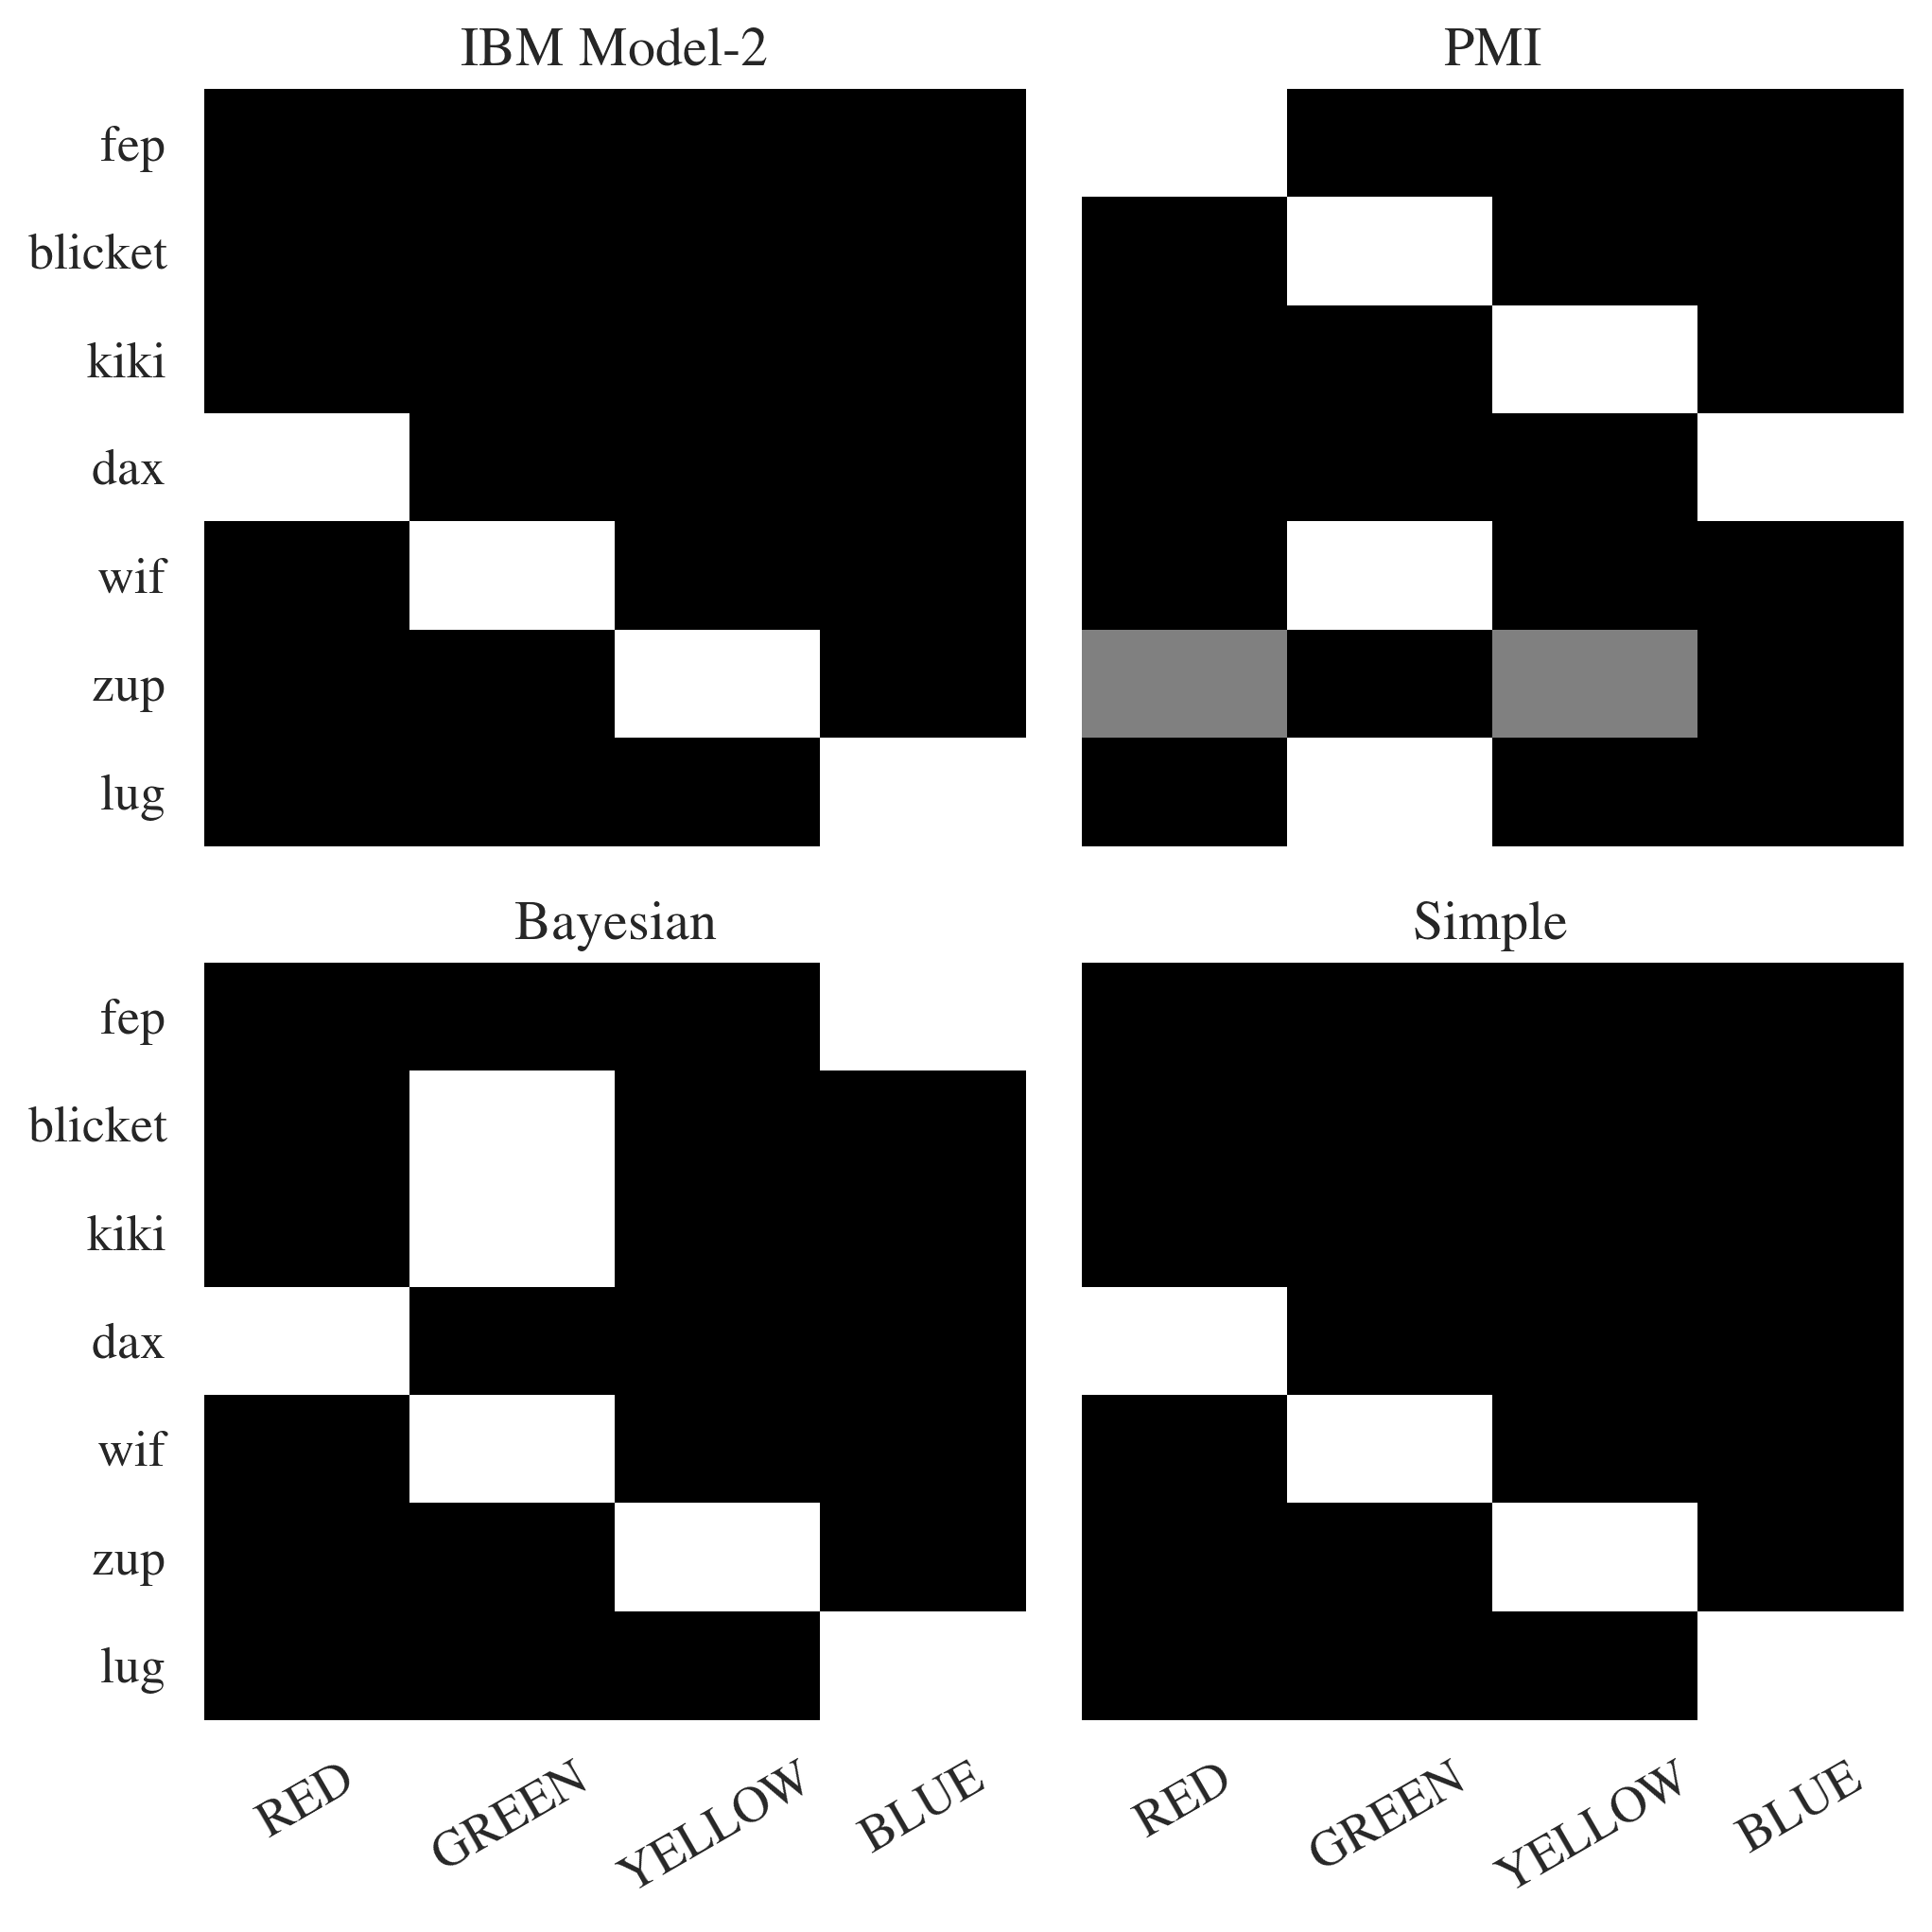

In [91]:
ar_index="fep blicket kiki dax wif zup lug".split(" ")
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=True, sharex=True)
sns.despine(left=True)
pmi_ar, _ = get_heatmap_from_lexicon3(get_lexicon(colors_results, model='pmi'), file="figures/color_pmi.pdf", title='PMI', ax=axes[0,1])
pmi_ar = pmi_ar.loc[ar_index][["RED","GREEN","YELLOW","BLUE"]]
get_heatmap_from_lexicon3(get_lexicon(colors_results, model='simple'), file="figures/color_simple.pdf", title="Simple", reindex_df=pmi_ar, ax=axes[1,1])
get_heatmap_from_lexicon3(get_lexicon(colors_results, model='intersect'), file="figures/color_ibm2.pdf", title="IBM Model-2", reindex_df=pmi_ar, ax=axes[0,0])
get_heatmap_from_lexicon3(get_lexicon(colors_results, model='goodman'), file="figures/color_goodman.pdf", title='Bayesian', reindex_df=pmi_ar, ax=axes[1,0])
f.savefig("figures/colors.pdf", dpi=300)

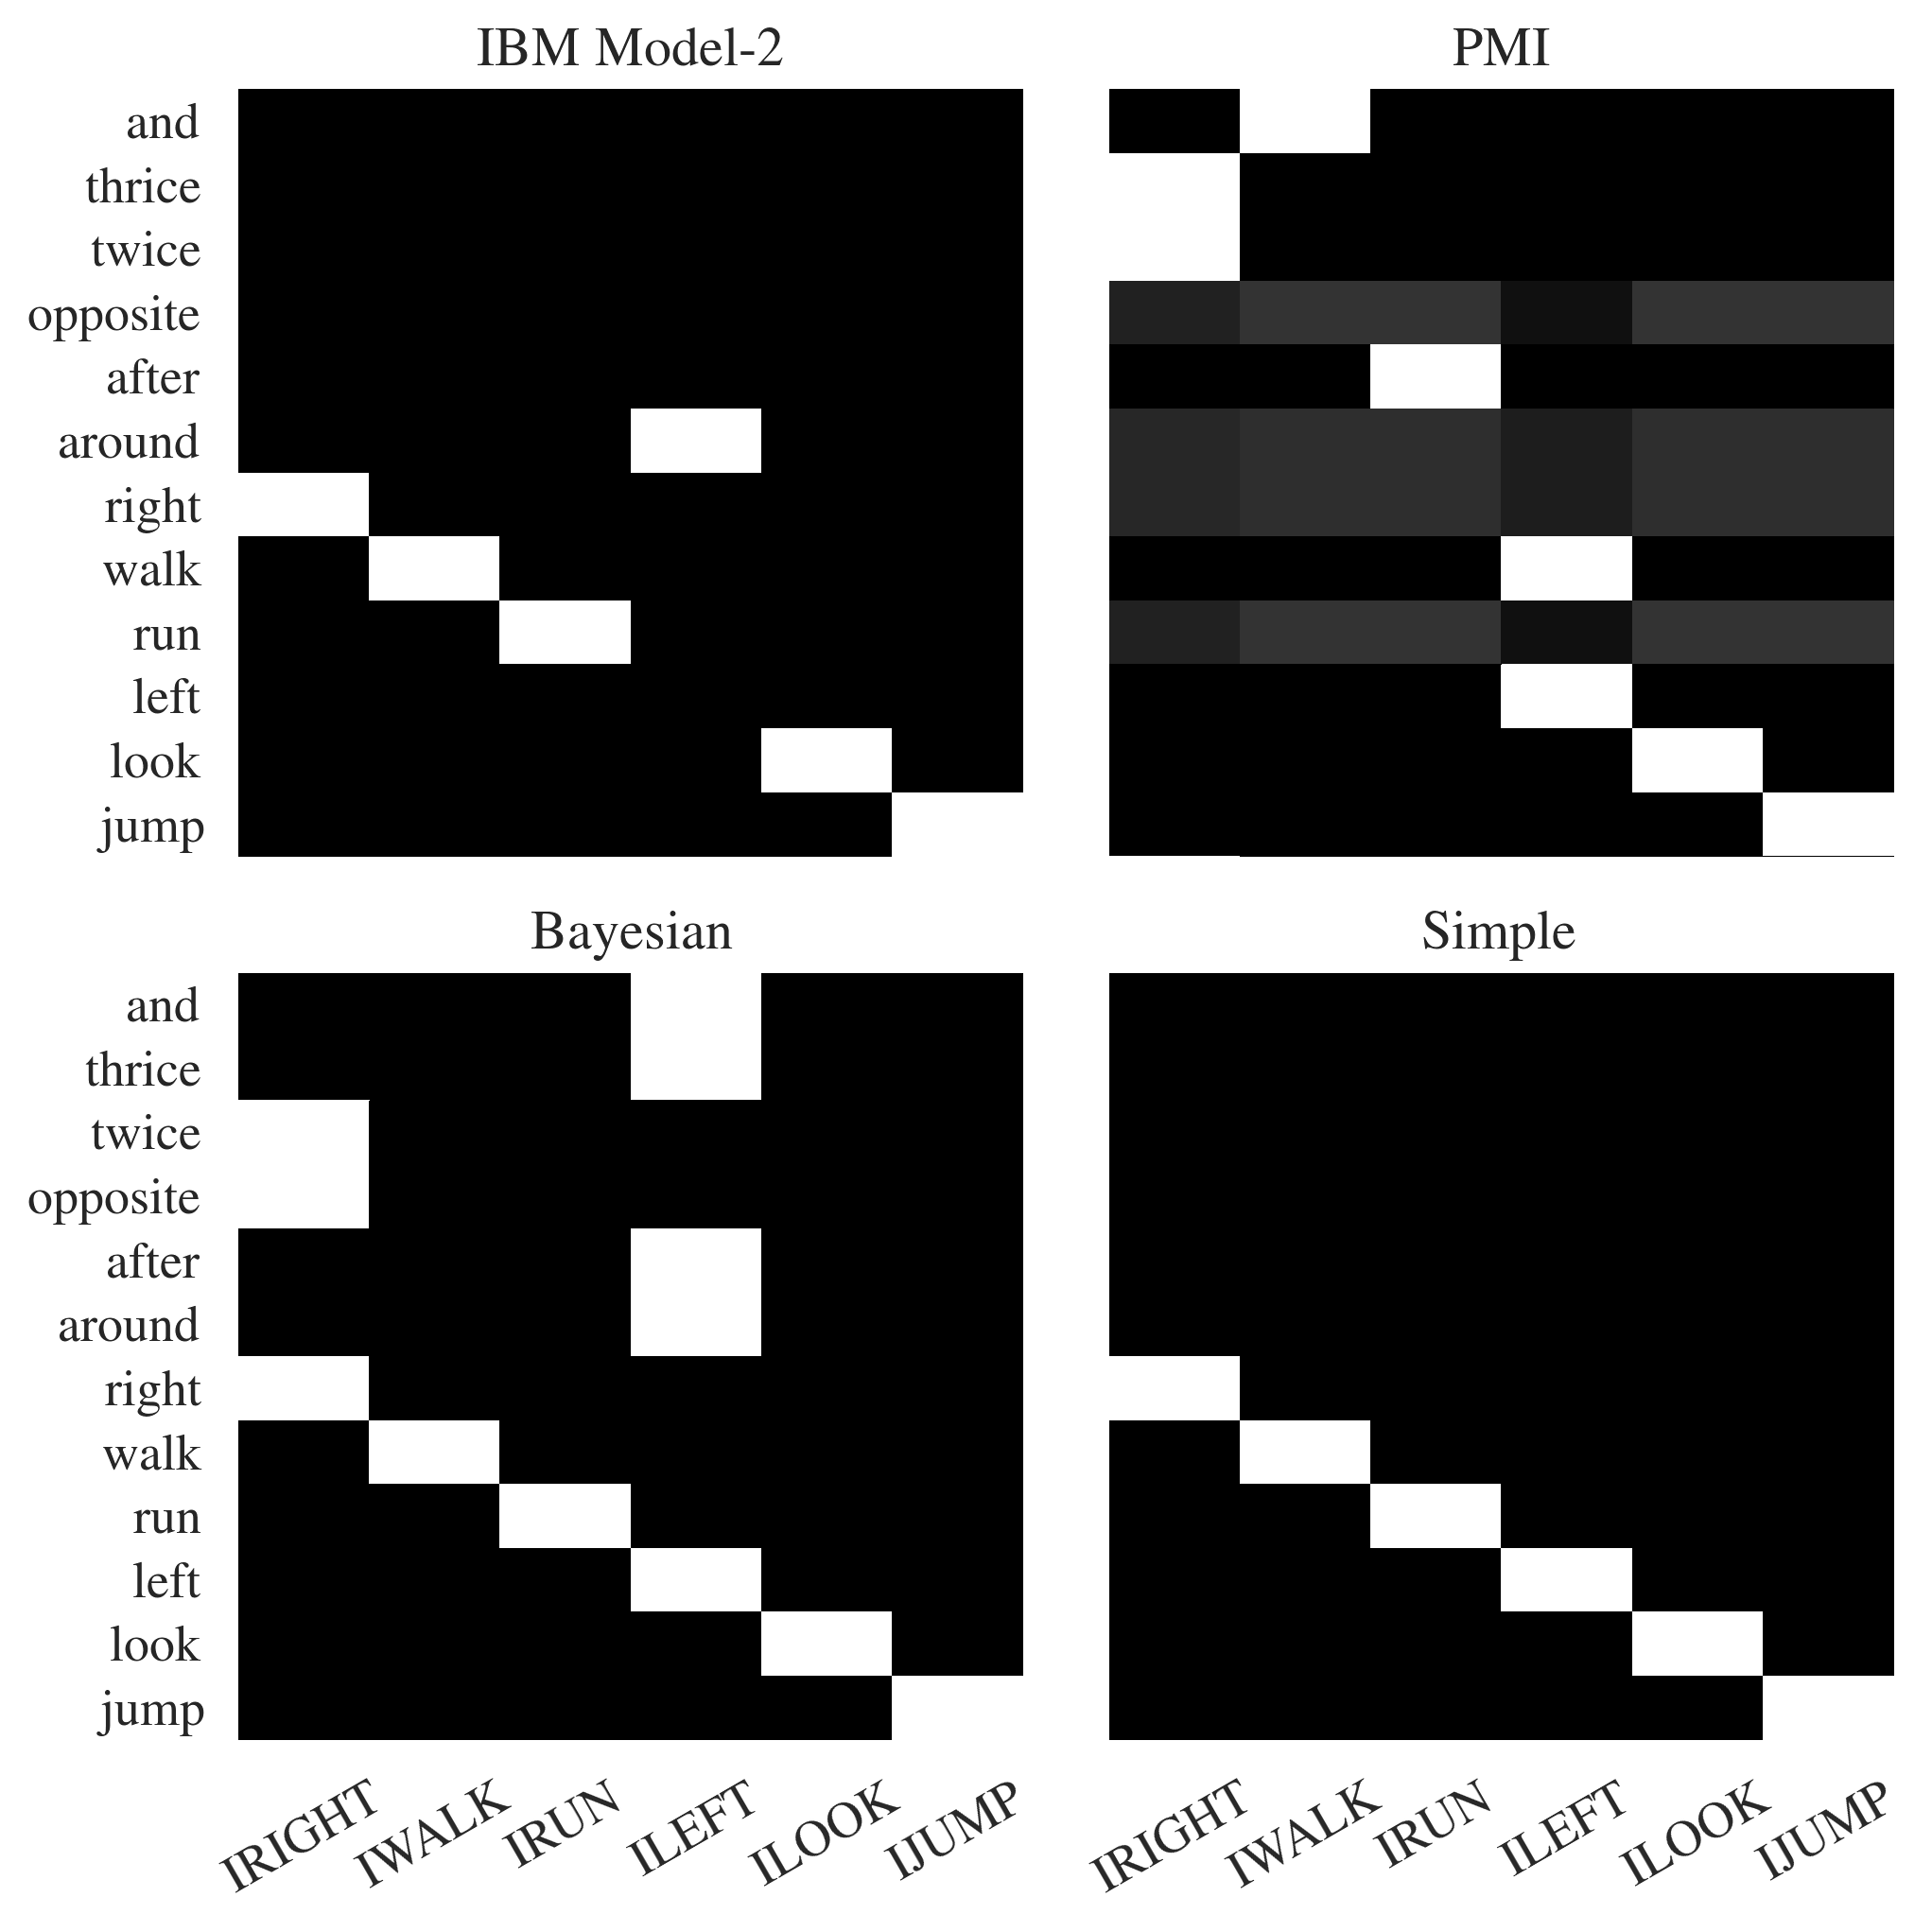

In [92]:
ar_index="and thrice twice opposite after around right walk run left look jump".split(" ")
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=True, sharex=True)
sns.despine(left=True)
pmi_ar, _ = get_heatmap_from_lexicon3(get_lexicon(around_right_results, model='pmi'), file="figures/around_right_pmi.pdf", title='PMI', ax=axes[0,1])
pmi_ar = pmi_ar.loc[ar_index]
get_heatmap_from_lexicon3(get_lexicon(around_right_results, model='simple'), file="figures/around_right_simple.pdf", title="Simple", reindex_df=pmi_ar, ax=axes[1,1])
get_heatmap_from_lexicon3(get_lexicon(around_right_results, model='intersect'), file="figures/around_right_ibm2.pdf", title="IBM Model-2", reindex_df=pmi_ar, ax=axes[0,0])
get_heatmap_from_lexicon3(get_lexicon(around_right_results, model='goodman'), file="figures/around_right_goodman.pdf", title='Bayesian', reindex_df=pmi_ar, ax=axes[1,0])
f.savefig("figures/around_right.pdf", dpi=300)

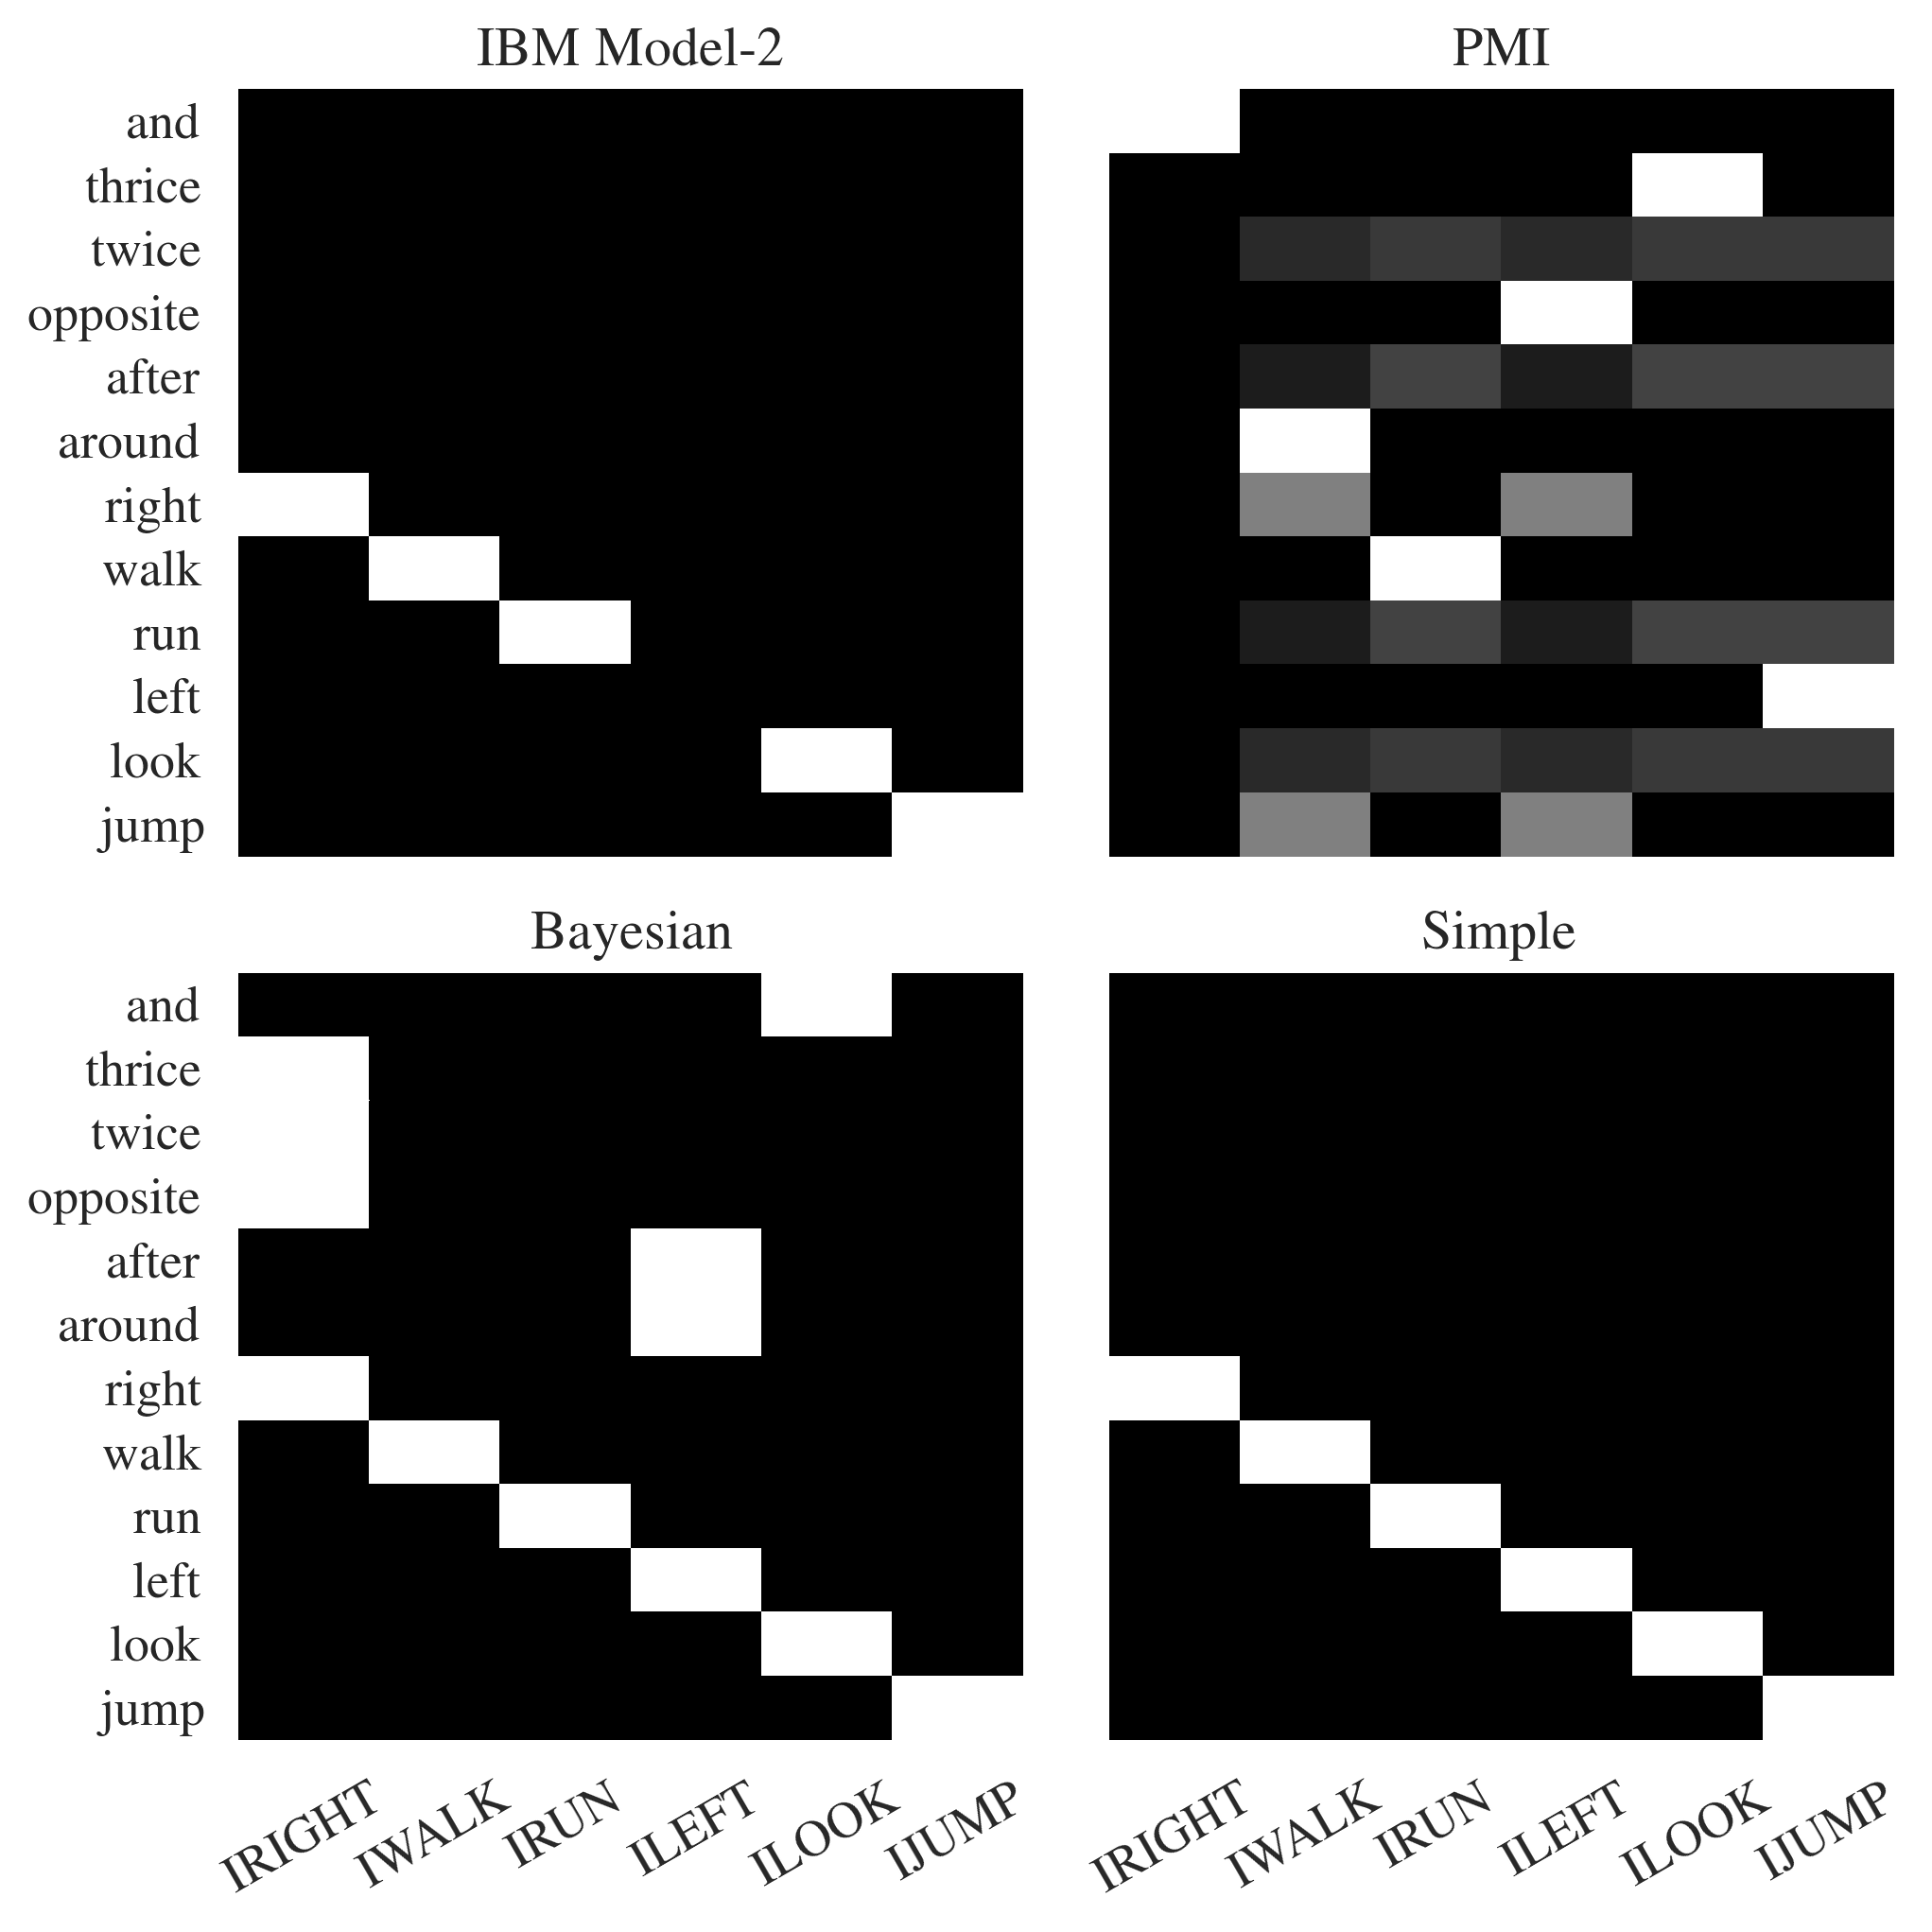

In [93]:
ar_index="and thrice twice opposite after around right walk run left look jump".split(" ")
cols = "IRIGHT IWALK IRUN ILEFT ILOOK IJUMP".split(" ")
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=True, sharex=True)
sns.despine(left=True)
pmi_ar, _ = get_heatmap_from_lexicon3(get_lexicon(jump_results, model='pmi'), file="figures/jump_pmi.pdf", title='PMI', ax=axes[0,1])
pmi_ar = pmi_ar.loc[ar_index][cols]
get_heatmap_from_lexicon3(get_lexicon(jump_results, model='simple'), file="figures/jump_simple.pdf", title="Simple", reindex_df=pmi_ar, ax=axes[1,1])
get_heatmap_from_lexicon3(get_lexicon(jump_results, model='intersect'), file="figures/jump_ibm2.pdf", title="IBM Model-2", reindex_df=pmi_ar, ax=axes[0,0])
get_heatmap_from_lexicon3(get_lexicon(jump_results, model='goodman'), file="figures/jump_goodman.pdf", title='Bayesian', reindex_df=pmi_ar, ax=axes[1,0])
f.savefig("figures/jump.pdf", dpi=300)

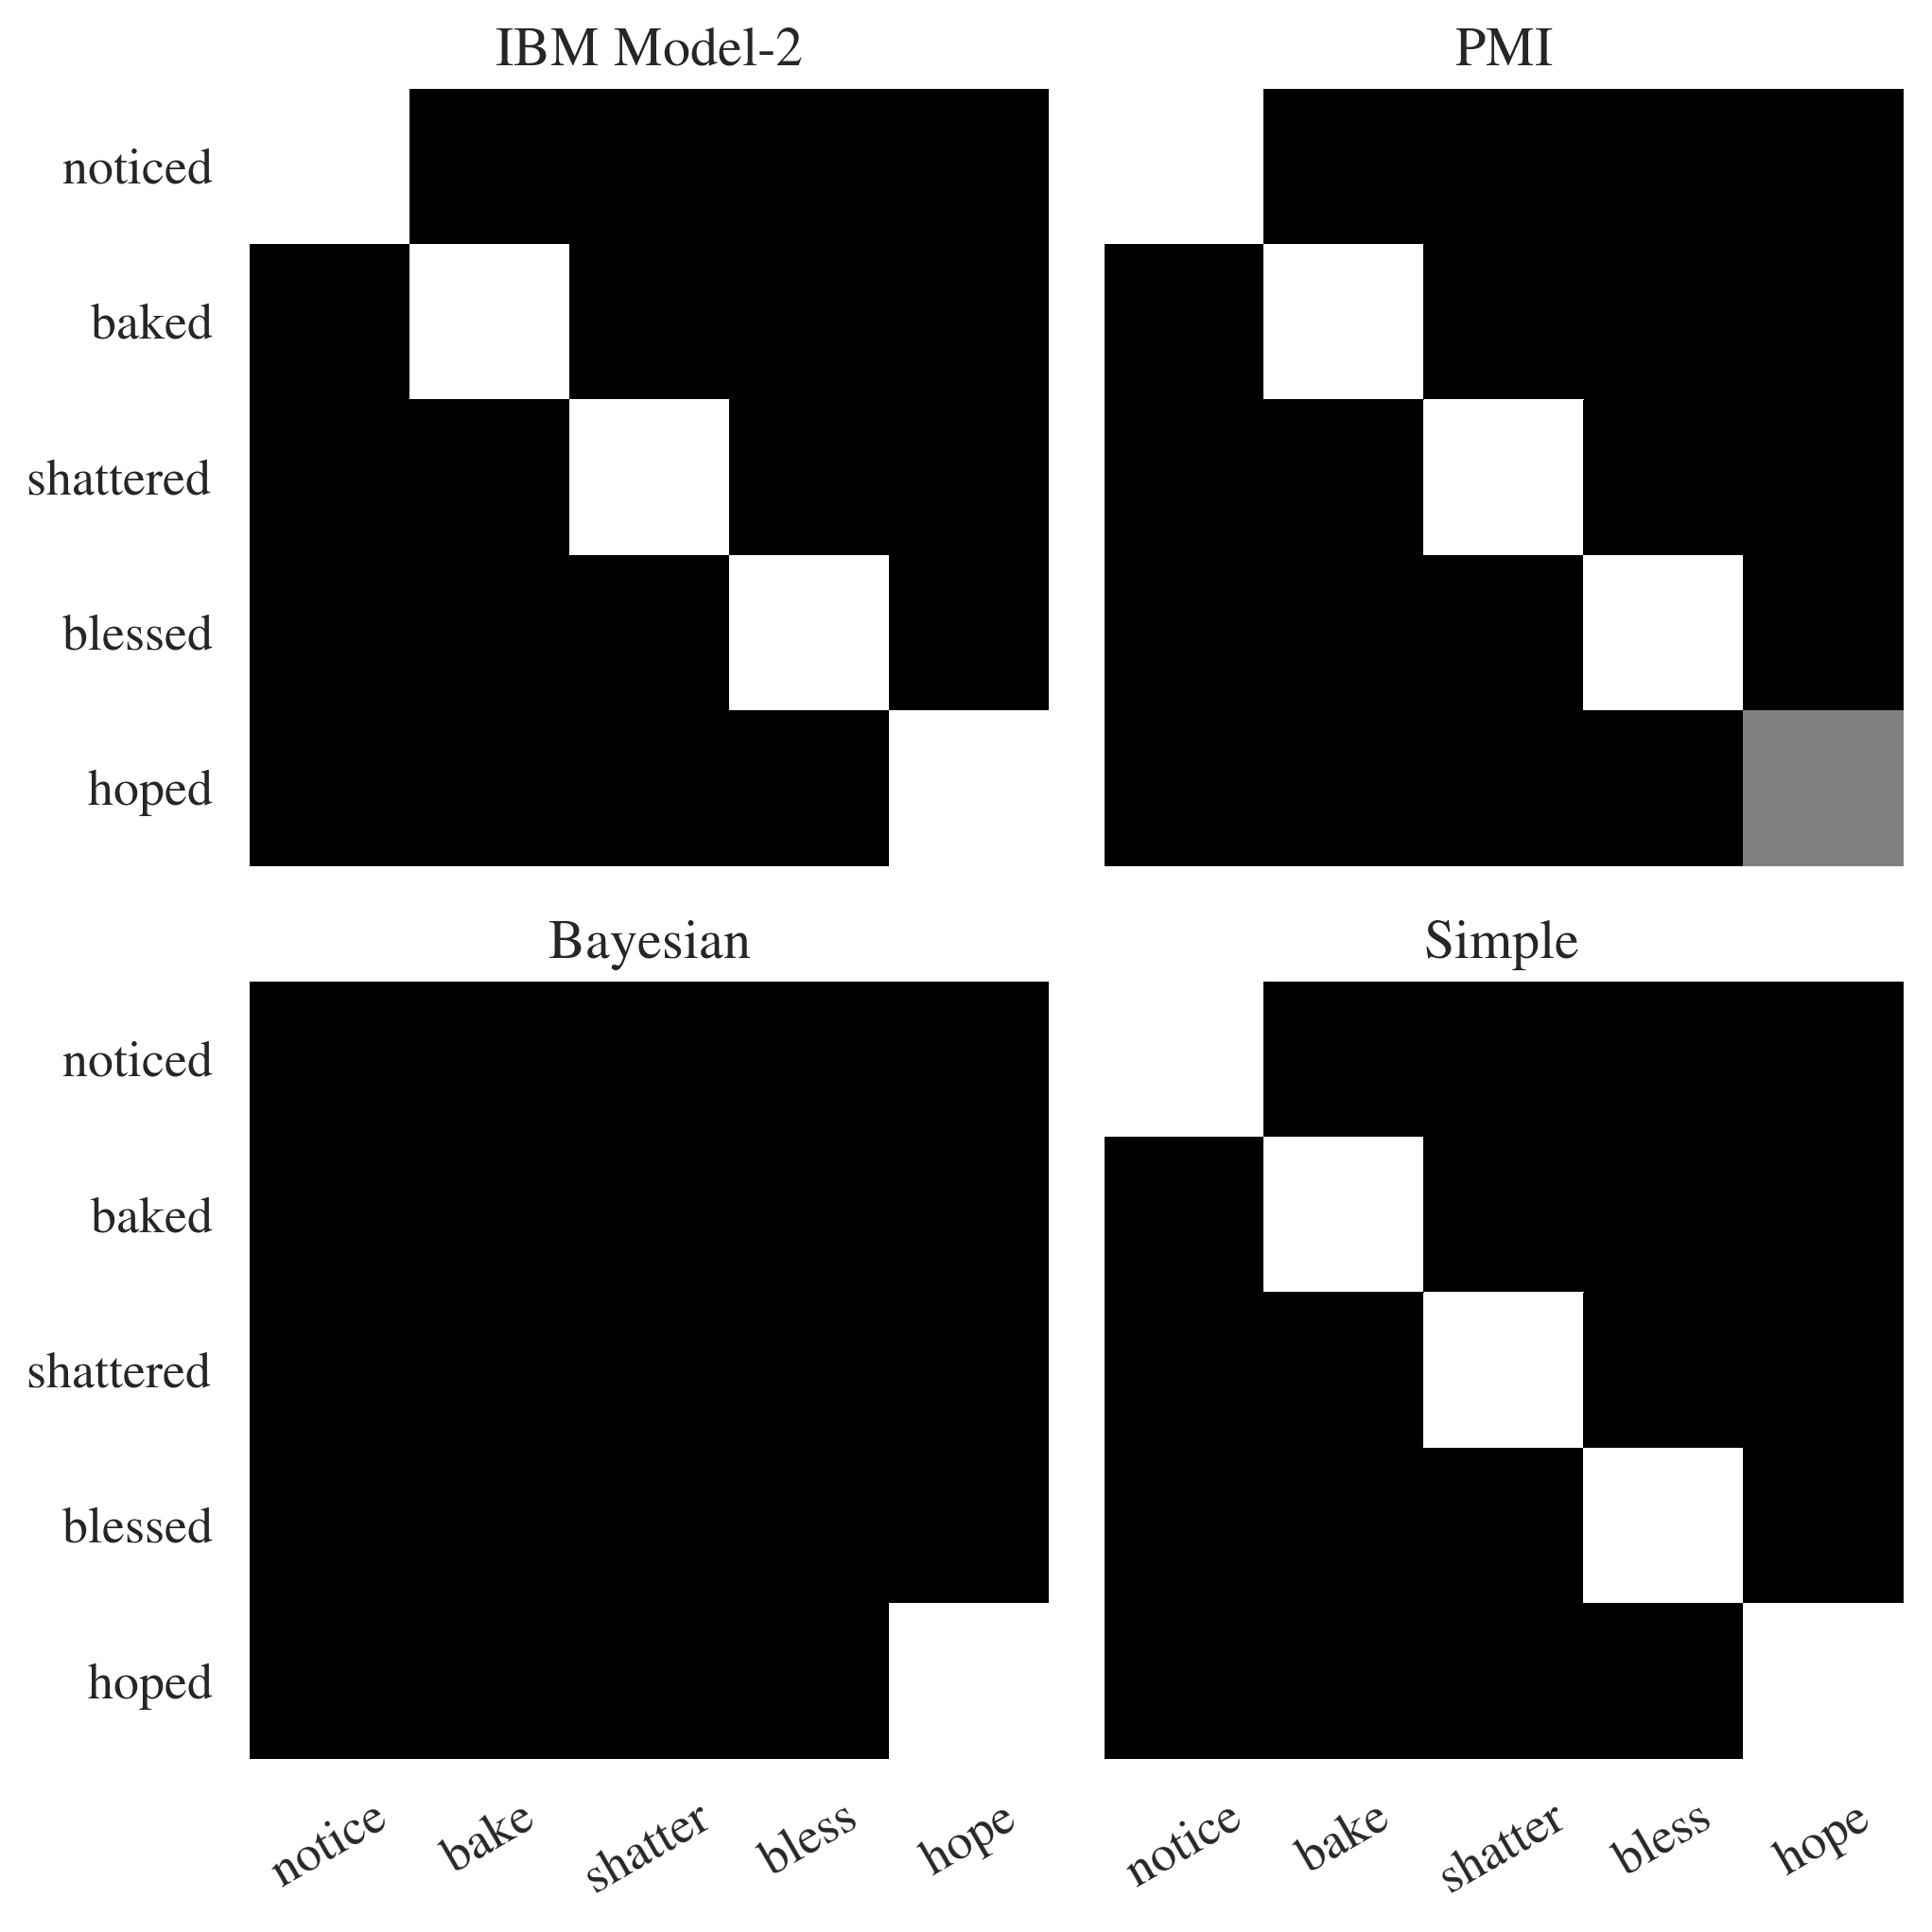

In [94]:
cogs_input_words  = ['noticed', 'baked', 'shattered', 'blessed','hoped']
cogs_output_words = ["notice", "bake", "shatter", "bless", "hope"]
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=True, sharex=True)
sns.despine(left=True)
simple_ar,_ = get_heatmap_from_lexicon3(get_lexicon(cogs_results, model='simple'), indices=cogs_input_words, columns=cogs_output_words, file="figures/cogs_simple.pdf", title="Simple",  ax=axes[1,1])
simple_ar = simple_ar.loc[cogs_input_words][cogs_output_words]
get_heatmap_from_lexicon3(get_lexicon(cogs_results, model='pmi'), file="figures/cogs_pmi.pdf", title='PMI', ax=axes[0,1], reindex_df=simple_ar)
get_heatmap_from_lexicon3(get_lexicon(cogs_results, model='intersect'), file="figures/cogs_ibm2.pdf", title="IBM Model-2", reindex_df=simple_ar, ax=axes[0,0])
get_heatmap_from_lexicon3(get_lexicon(cogs_results, model='goodman'),  file="figures/cogs_goodman.pdf", title='Bayesian', reindex_df=simple_ar, ax=axes[1,0])
f.savefig("figures/cogs.pdf", dpi=300)

# ABLATION II - Cogs Category Results

In [95]:
cogs_cat_results = {}
for m in ['lstm', 'lstmcopy', 'simple']:
    cogs_cat_results[m] = {}
    for cat in set(cogsinfo.data['gen_cats']):
        cogs_cat_results[m][cat] =  get_accuracy([result.results for result in cogs_results[m]],category=cat)
    cogs_cat_results[m]['all'] =  get_accuracy([result.results for result in cogs_results[m]])

In [96]:
cogs_cat_results

{'lstm': {'pp_dative_to_do_dative': 0.9654999999999999+/-0.0189802528961023,
  'only_seen_as_unacc_subj_as_obj_omitted_transitive_subj': 0.7748999999999999+/-0.18549741238087392,
  'obj_omitted_transitive_to_transitive': 0.43450000000000005+/-0.35146614346192717,
  'pp_recursion': 0.041499999999999995+/-0.012483989746871791,
  'obj_to_subj_common': 0.9181999999999999+/-0.21124099980827588,
  'obj_to_subj_proper': 0.5479999999999999+/-0.44094625522845754,
  'passive_to_active': 0.2273+/-0.20590582798939905,
  'only_seen_as_unacc_subj_as_unerg_subj': 0.7723+/-0.18591022026774107,
  'do_dative_to_pp_dative': 0.9841+/-0.01510926867852976,
  'cp_recursion': 0.0+/-0,
  'only_seen_as_transitive_subj_as_unacc_subj': 0.9224+/-0.11380263617333299,
  'subj_to_obj_common': 0.7792+/-0.16155358244248252,
  'prim_to_subj_common': 0.5506+/-0.37906310820231504,
  'unacc_to_transitive': 0.1606+/-0.28371401093354554,
  'active_to_passive': 0.9673999999999999+/-0.04584364732435672,
  'obj_pp_to_subj_pp': 

In [97]:
cogs_cat_table = pd.DataFrame(cogs_cat_results, columns=['lstm','lstmcopy','simple'], index=list(set(cogsinfo.data['gen_cats'])))

In [98]:
cogs_cat_table.style.format(u'& {:.2L}')

,lstm,lstmcopy,simple
pp_dative_to_do_dative,& 0.97 \pm 0.02,& 0.63 \pm 0.33,& 0.99 \pm 0.01
only_seen_as_unacc_subj_as_obj_omitted_transitive_subj,& 0.77 \pm 0.19,& 0.99 \pm 0.02,& 1.0 \pm 0.0
obj_omitted_transitive_to_transitive,& 0.43 \pm 0.35,& 0.026 \pm 0.046,& 1.0 \pm 0.0
pp_recursion,& 0.041 \pm 0.012,& 0.0018 \pm 0.0028,& 0.013 \pm 0.016
obj_to_subj_common,& 0.92 \pm 0.21,& 1.0 \pm 0.0,& 1.0 \pm 0.0
obj_to_subj_proper,& 0.55 \pm 0.44,& 0.99 \pm 0.00,& 1.0 \pm 0.0
passive_to_active,& 0.23 \pm 0.21,& 0.47 \pm 0.28,& 1.0 \pm 0.0
only_seen_as_unacc_subj_as_unerg_subj,& 0.77 \pm 0.19,& 0.99 \pm 0.01,& 1.0 \pm 0.0
do_dative_to_pp_dative,& 0.98 \pm 0.02,& 0.88 \pm 0.17,& 0.99 \pm 0.00
cp_recursion,& 0.0 \pm 0,& 0.0 \pm 0,& 0.00030 \pm 0.00064


# ABLATION  - Soft / Learned / Random

In [99]:
def cogs_ablation(datainfo=None):    
    exp_folders = {"simple":cogs_home + "simple/",
                   "soft":cogs_home + "soft_temp_0.2_simple/",
                   "learned":cogs_home + "learn_temp_0.2_simple/",
                   "uniform":cogs_home + "learn_uniform_temp_0.2/",
                   "random":cogs_home + "learn_random_temp_0.2/" }
    return read_all_results(exp_folders,"cogs", datainfo=datainfo, read_category=True)

In [100]:
cogs_ablation_significance = {}

In [ ]:
cogs_ablation_results = cogs_ablation(cogsinfo)

In [ ]:
# translate_ablation_results = translate_ablation(translateinfo)

In [ ]:
ablation_scores = {}
for (exp_name, results) in cogs_ablation_results.items():
    ablation_scores[exp_name] = {"acc":get_accuracy([result.results for result in results])}

In [ ]:
cogs_ablation_results.pop('random')
update_significance(cogs_ablation_results,cogs_ablation_significance)

In [ ]:
pd.DataFrame(cogs_ablation_significance)

In [ ]:
# ablation_scores2 = {}
# for (exp_name, results) in translate_ablation_results.items():
#     ablation_scores2[exp_name] = {"bleu":get_bleu([result.results for result in results])}

In [ ]:
# ablation_scores

In [ ]:
# ablation_scores2

In [ ]:
cogs_ablation_table = pd.DataFrame(ablation_scores, index=["acc"],columns=list(ablation_scores.keys()))

In [ ]:
cogs_ablation_table.transpose().style.format(u'& {:.4P}')

In [ ]:
# translate_ablation_table = pd.DataFrame(ablation_scores2, index=["bleu"],columns=list(ablation_scores2.keys()))

In [ ]:
# translate_ablation_table.transpose().style.format(u'& {:.2uP}')

In [ ]:
for m in ['soft', 'learned', 'uniform']:
    cogs_cat_results[m] = {}
    for cat in set(cogsinfo.data['gen_cats']):
        cogs_cat_results[m][cat] =  get_accuracy([result.results for result in cogs_ablation_results[m]],category=cat)
    cogs_cat_results[m]['all'] =  get_accuracy([result.results for result in cogs_ablation_results[m]])

In [ ]:
selective_index = """prim_to_inf_arg
prim_to_subj_proper
active_to_passive
obj_pp_to_subj_pp
passive_to_active
pp_recursion
obj_omitted_transitive_to_transitive
prim_to_obj_proper
unacc_to_transitive
obj_to_subj_proper
prim_to_obj_common
subj_to_obj_common
cp_recursion
pp_dative_to_do_dative
prim_to_subj_common
all""".split("\n")

In [ ]:
selective_index = """prim_to_
active_to_passive
obj_pp_to_subj_pp
passive_to_active
p_recursion
unacc_to_transitive
obj_to_subj_proper
subj_to_obj_common
dative
all""".split("\n")

In [ ]:
for m in ['lstm', 'lstmcopy', 'simple']:
    cogs_cat_results[m] = {}
    for cat in selective_index:
        print(cat)
        cogs_cat_results[m][cat] =  get_accuracy([result.results for result in cogs_results[m]],category=cat)
    cogs_cat_results[m]['all'] =  get_accuracy([result.results for result in cogs_results[m]])

In [ ]:
#cogs_cat_table2 = pd.DataFrame(cogs_cat_results, columns=['lstm','lstmcopy','uniform','simple', 'soft', 'learned'], index=selective_index)
cogs_cat_table2 = pd.DataFrame(cogs_cat_results, columns=['lstm','lstmcopy','simple'], index=selective_index)

In [ ]:
cogs_cat_table2

In [ ]:
(cogs_cat_table2*8).transpose().style.format(u'\mybar{{ {:.2ufP} }}')

In [ ]:
print((cogs_cat_table2*8).to_latex(formatters=[u'\mybar{{ {:.2ufP} }}'.format]*3, escape=False).replace("±","}{"))

## Colors Detailed Results

In [ ]:
def sort_inputs(results):
    return sorted(results, key=lambda k: k['input'])

In [ ]:
colors_details = {"examples":[]}
results = sort_inputs(colors_results["simple"][0].results)
for k in range(len(results)):
    colors_details["examples"].append(" ".join(results[k]['input']))
for model in ("simple","goodman","geca","synatt"):
    colors_details[model] = []
    for k in range(len(colors_results[model][0].results)):
        colors_details[model].append(mean_std([sort_inputs(colors_results[model][i].results)[k]['label'] for i in range(16)]))    

In [ ]:
colors_details

In [ ]:
print(pd.DataFrame(colors_details).to_latex(escape=False, index=False))

In [ ]:
print(pd.DataFrame(colors_details).iloc[[7,9,2,0,4,3,8,1,5,6]].to_latex(escape=False, index=False))

In [ ]:
# alignments = json.load(open("COGS/cogs/alignments/simple.align.v3.json"))
# fastalign = json.load(open("COGS/cogs/alignments/intersect.align.o.json"))

In [ ]:
# def visualize_model(mfile, viswords=None, n=None):
#     model = torch.load(mfile, map_location=torch.device('cpu'))
#     vocab_x = list(model.vocab_x._contents.keys())
#     vocab_y = list(model.vocab_y._contents.keys())
#     input_embeddings = model.pyx.encoder.embed.weight.detach().cpu().numpy()
#     output_embeddings = model.pyx.decoder.embed.weight.detach().cpu().numpy()
# #     print(input_embeddings.shape)
# #     print(output_embeddings.shape)
#     #Y = TSNE(n_components=2).fit_transform(input_embeddings)
#     #print(Y.shape)
#     if n is None:
#         n = len(vocab_x) + 1
#     Y = TSNE(n_components=2, random_state=0).fit_transform(input_embeddings[0:n])
#     tsne_plot(Y, vocab_x[0:n], viswords)


In [ ]:
# def tsne_plot(embeddings, words, viswords=None, filename=None):
#     ax = plt.figure(figsize=(5, 3))
#     if viswords is not None:
#         indices = [words.index(w) for w in viswords]
#     x = embeddings[indices, 0]
#     y = embeddings[indices, 1]
#     plt.scatter(x, y, s=2)
#     for (i,ind) in enumerate(indices):
#         if viswords is None or words[ind] in viswords:
#             plt.annotate(words[ind], alpha=0.8, xy=(x[i], y[i]),  xytext=(1, 2), textcoords='offset points', size=6, label=None)
#     plt.title("Embbeding Viz")
#     if filename:
#         plt.savefig(filename, format='png', dpi=245, bbox_inches='tight')
#     plt.show()


In [ ]:
# around_right_mfile1 = "exp/SCAN/aligner_jump_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/cogs_baseline_seed_0_model.m"
# around_right_mfile2 = "exp/SCAN/LSTM_jump_SCAN_nbatch_128_lr_1.0_warmup_4000_max_8000/cogs_baseline_seed_0_model.m"

In [ ]:
# viswords = "jump right left turn around walk look after twice thrice and".split()

In [ ]:
# visualize_model(around_right_mfile1, viswords)

In [ ]:
# visualize_model(around_right_mfile2,viswords)